# Natural Language Processing Project
## NLP Course @ Politecnico di Milano 2024/2025 - Prof. Mark Carman
### Topic 8: Medical Question Answering
Dataset: 
* PubMedQA [link](https://huggingface.co/datasets/qiaojin/PubMedQA )

Reference paper:
* PubMedQA: A Dataset for Biomedical Research Question Answering [Link](https://arxiv.org/pdf/1909.06146)

## Group members:

* Ketrin Mehmeti
* Giulia Ghiazza
* Leonardo Giorgio Franco
* Edoardo Franco Mattei
* Alessandro Epifania

## Libraries and Dataset Loading

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ASUS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\ASUS/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Loading the dataset: 

The object dataset is a DatasetDict, and in this case instead of different splits like "train", "validation", and "test" contains only the "train" section. 


In [3]:
# Load the labeled, unlabeled, and artificial subsets of PubMedQA
# The dataset is split into three subsets:

dataset_labeled = load_dataset("qiaojin/PubMedQA", 'pqa_labeled')               
dataset_unlabeled = load_dataset("qiaojin/PubMedQA", 'pqa_unlabeled')    
dataset_artificial = load_dataset('qiaojin/PubMedQA', 'pqa_artificial')  

In [4]:
print("Labeled dataset:", dataset_labeled)
print("Artificial dataset:", dataset_artificial)
print("Unlabeled dataset:", dataset_unlabeled)

# Notice that the feature final_decision is missing in the Unlabeled dataset, reflecting the fact 
# that these examples do not have a definitive yes/no/maybe label.

Labeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 1000
    })
})
Artificial dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 211269
    })
})
Unlabeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer'],
        num_rows: 61249
    })
})


In [5]:
print(dataset_labeled.keys())
print(dataset_artificial.keys())
print(dataset_unlabeled.keys())

dict_keys(['train'])
dict_keys(['train'])
dict_keys(['train'])


In [6]:
# Convert the datasets to pandas DataFrames for easier manipulation
df_labeled_original = pd.DataFrame(dataset_labeled['train'])
df_unlabeled_original = pd.DataFrame(dataset_unlabeled['train'])
df_artificial_original = pd.DataFrame(dataset_artificial['train'])

In [7]:
# Make a copy of the original datasets to work on
df_labeled = df_labeled_original.copy()
df_unlabeled = df_unlabeled_original.copy()
df_artificial = df_artificial_original.copy()

# First step: Preliminary analysis
Briefly describe the data:
- What is the structure of the dataset? What type of task was the dataset collected for?
- What type of documents does it contain? How many are there? How long are they on average and
what is their distribution?
- How big is the vocabulary of the collection? How big is the vocabulary of a document on average?

Play around with documents using code from the early parts of the course. For example, you could:
- Cluster the documents, visualise the clusters and to try to understand what types of groups are
present.
- Index the documents so that you can perform keyword search over them.
- Train a Word2Vec embedding and investigate the properties of the resulting embedding.

## Dataset Description

In [8]:
# Check the data types of individual elements in each feature (question, context, long_answer)
# across the labeled, unlabeled, and artificial datasets. This is useful to verify that all elements 
# are strings before applying any text processing or tokenization functions, since functions from 
# libraries like Hugging Face's Transformers typically expect string inputs.

print(type(df_labeled['question'][0]))
print(type(df_labeled['context'][0]))
print(type(df_labeled['long_answer'][0]))
print(" ")

print(type(df_unlabeled['question'][0]))
print(type(df_unlabeled['context'][0]))
print(type(df_unlabeled['long_answer'][0]))
print(" ")

print(type(df_artificial['question'][0]))
print(type(df_artificial['context'][0]))
print(type(df_artificial['long_answer'][0]))

<class 'str'>
<class 'dict'>
<class 'str'>
 
<class 'str'>
<class 'dict'>
<class 'str'>
 
<class 'str'>
<class 'dict'>
<class 'str'>


### "Context" Analysis

In [9]:
# Each 'context' entry is a dictionary containing multiple keys.
# In the labeled dataset, each context includes:
# - 'contexts': a list of textual context passages
# - 'labels': a list of associated labels
# - 'meshes': a list of medical subject headings
# - 'reasoning_required_pred': a list indicating whether reasoning is required (only in labeled)
# - 'reasoning_free_pred': a list indicating whether the question is reasoning-free (only in labeled)
# 
# In contrast, the unlabeled and artificial datasets contain only:
# - 'contexts', 'labels', and 'meshes'
# 
# This structural difference is important when preprocessing the data, 
# since some fields (e.g., 'reasoning_required_pred') are not available across all datasets.


for key, value in df_labeled['context'][0].items():
    print(f"{key}: {type(value)}")

print(" ")

for key, value in df_unlabeled['context'][0].items():
    print(f"{key}: {type(value)}")

print(" ")

for key, value in df_artificial['context'][0].items():
    print(f"{key}: {type(value)}")

contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
reasoning_required_pred: <class 'list'>
reasoning_free_pred: <class 'list'>
 
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
 
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>


We then start to calculate various parameters regarding the the "contexts" list.

In [10]:
# AVERAGE NUMBER OF SEGMENTS IN "CONTEXTS"

# This line calculates the average number of segments (i.e., separate strings) within the 'contexts' field of each instance.
# In the PubMedQA dataset, the abstract is split into multiple segments in the 'contexts' list to reflect its original sentence-level structure.
# This allows for more granular control when processing biomedical abstracts, especially for tasks that involve reasoning over specific parts of the text.
# Note: This does NOT measure the length in characters or words, only the number of abstract segments.

print("Average number of segments in contexts in the labeled dataset:", df_labeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the unlabeled dataset:", df_unlabeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the artificial dataset:", df_artificial['context'].apply(lambda x: len(x['contexts'])).mean())

Average number of segments in contexts in the labeled dataset: 3.358
Average number of segments in contexts in the unlabeled dataset: 3.3185031592352527
Average number of segments in contexts in the artificial dataset: 3.1005732028835276


In [11]:
# AVERAGE LENGTH OF "CONTEXTS"

# Here we join all the abstract segments (stored in the 'contexts' list) into a single string for each instance.
# This allows us to compute the average abstract length in terms of number of words, rather than number of segments.
# It's useful to understand how verbose or detailed the contexts are in natural language.

context_word_lengths_L = df_labeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the labeled dataset:", context_word_lengths_L.mean())
print("Standard deviation of words in abstract in the labeled dataset:", context_word_lengths_L.std())
print(" ")

context_word_lengths_U = df_unlabeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the unlabeled dataset:", context_word_lengths_U.mean())
print("Standard deviation of words in abstract in the unlabeled dataset:", context_word_lengths_U.std())
print(" ")

context_word_lengths_A = df_artificial['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the artificial dataset:", context_word_lengths_A.mean())
print("Standard deviation of words in abstract in the artificial dataset:", context_word_lengths_A.std())


Average number of words in abstract in the labeled dataset: 200.207
Standard deviation of words in abstract in the labeled dataset: 51.84642903038938
 
Average number of words in abstract in the unlabeled dataset: 198.7389018596222
Standard deviation of words in abstract in the unlabeled dataset: 56.65423030078211
 
Average number of words in abstract in the artificial dataset: 200.51420700623376
Standard deviation of words in abstract in the artificial dataset: 50.70859241655663


The average number of words in the abstract ('context') is very similar across the labeled, unlabeled, and artificial datasets, with means around 200 words. This consistency suggests that the datasets are well-aligned in terms of content length. 
Additionally, the standard deviations are comparable, indicating a similar spread and variability in abstract lengths.
These observations support the assumption that the datasets are structurally balanced and comparable for downstream tasks.

### "Question" Analysis

In [12]:
question_word_lengths_L = df_labeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the labeled dataset:", question_word_lengths_L.mean())
print("Standard deviation of words in question in the labeled dataset:", question_word_lengths_L.std())
print(" ")

question_word_lengths_U = df_unlabeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the unlabeled dataset:", question_word_lengths_U.mean())
print("Standard deviation of words in question in the unlabeled dataset:", question_word_lengths_U.std())
print(" ")

question_word_lengths_A = df_artificial['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the artificial dataset:", question_word_lengths_A.mean())
print("Standard deviation of words in question in the artificial dataset:", question_word_lengths_A.std())

Average number of words in question in the labeled dataset: 12.913
Standard deviation of words in question in the labeled dataset: 4.100517680152744
 
Average number of words in question in the unlabeled dataset: 13.34506685823442
Standard deviation of words in question in the unlabeled dataset: 4.567043839545208
 
Average number of words in question in the artificial dataset: 15.344096862294043
Standard deviation of words in question in the artificial dataset: 3.898447348860483


The average number of words in the 'question' field is slightly higher in the artificial dataset (~15.3 words) compared to the labeled (~12.9) and unlabeled (~13.3) datasets. Despite this difference, the standard deviations remain fairly close, indicating that the overall variability is consistent. This suggests that while artificial questions tend to be a bit longer, the distribution of their lengths is not drastically different, maintaining a reasonable alignment across datasets.

### "Long Answer" Analysis

In [13]:
long_answ_lengths_L = df_labeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the labeled dataset:", long_answ_lengths_L.mean())
print("Standard deviation of long_answer in the labeled dataset:", long_answ_lengths_L.std())
print(" ")

long_answ_lengths_U = df_unlabeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the unlabeled dataset:", long_answ_lengths_U.mean())
print("Standard deviation of long_answer in the unlabeled dataset:", long_answ_lengths_U.std())
print(" ")

long_answ_lengths_A = df_artificial['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the artificial dataset:", long_answ_lengths_A.mean())
print("Standard deviation of long_answer in the artificial dataset:", long_answ_lengths_A.std())

Average number of words in long_answer in the labeled dataset: 39.66
Standard deviation of long_answer in the labeled dataset: 17.209432430053138
 
Average number of words in long_answer in the unlabeled dataset: 42.02336364675342
Standard deviation of long_answer in the unlabeled dataset: 19.817240489404714
 
Average number of words in long_answer in the artificial dataset: 37.593660215175916
Standard deviation of long_answer in the artificial dataset: 18.49701353631026


The average number of words in the 'long_answer' field is relatively similar across the three datasets, ranging from approximately 37.6 to 42.0 words. 
The standard deviations are also comparable, suggesting that the variability in long answer lengths is consistent. Overall, there are no significant discrepancies in length distribution.

### "Final Decision" Analysis

In [14]:
# Count of 'final_decision' labels in Labeled and Artificial datasets

print(f"Occurrences of 'yes' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['no']}")
print(f"Occurrences of 'maybe' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['maybe']}")
print(" ")

print(f"Occurrences of 'yes' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['no']}")

Occurrences of 'yes' as the final decision in the Labeled dataset: 552
Occurrences of 'no' as the final decision in the Labeled dataset: 338
Occurrences of 'maybe' as the final decision in the Labeled dataset: 110
 
Occurrences of 'yes' as the final decision in the Artificial dataset: 196144
Occurrences of 'no' as the final decision in the Artificial dataset: 15125


The number of 'no' in the artificial dataset appears to be much smaller that the number of 'yes', indicating an unbalanced dataset.

We can visualize the difference between the two dataset by plotting the percentage distribution of final decision labels ('yes', 'no', 'maybe') for both the labeled and artificial datasets using side-by-side bar charts.


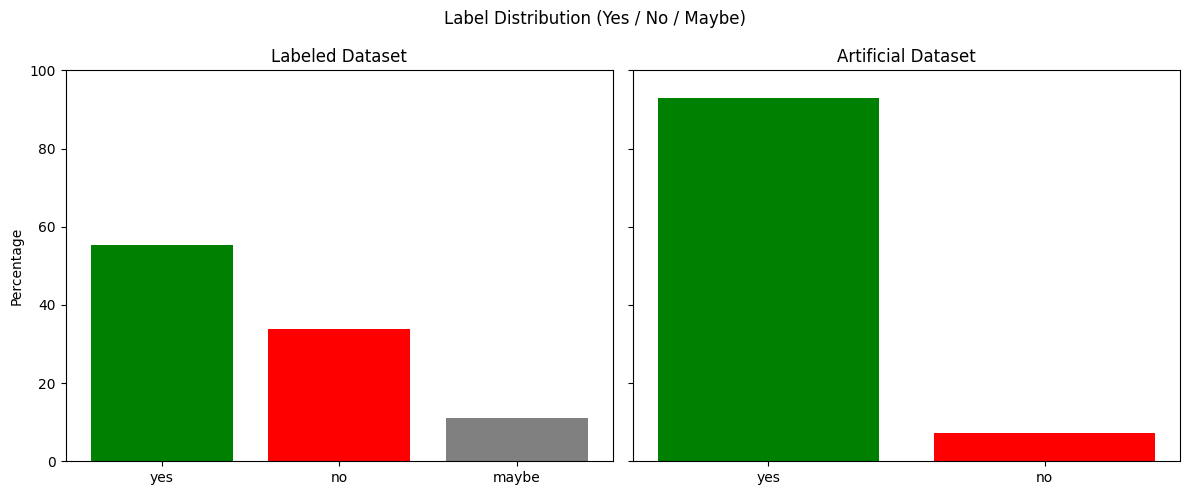

In [15]:
# Create subplots with shared y-axis to ensure the same scale across both bar plots.
# This makes it easier to visually compare the distribution of 'yes', 'no', and 'maybe' labels
# between the labeled and artificial datasets.

# Count label frequencies
labeled_counts = df_labeled['final_decision'].value_counts(normalize=True) * 100  
artificial_counts = df_artificial['final_decision'].value_counts(normalize=True) * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot labeled dataset
axes[0].bar(labeled_counts.index, labeled_counts.values, color=['green', 'red', 'gray'])
axes[0].set_title("Labeled Dataset")
axes[0].set_ylabel("Percentage")
axes[0].set_ylim(0, 100)

# Plot artificial dataset
axes[1].bar(artificial_counts.index, artificial_counts.values, color=['green', 'red', 'gray'])
axes[1].set_title("Artificial Dataset")
axes[1].set_ylim(0, 100)

plt.suptitle("Label Distribution (Yes / No / Maybe)")
plt.tight_layout()
plt.show()


### Vocabulary Analysis

The aim of this section is to build and analyse a preliminary vocabulary (before preprocessing) for each dataset. <br>
The analysis will be repeated after the lemmization to compare the results. <br>
We start by building a function to compute the vocabulary. 

In [16]:
# Define a function to build a vocabulary counter from a list of texts:
# it lowercases the text, filters out stopwords and non-alphabetic tokens,
# and counts the frequency of each remaining word.

nltk.download('stopwords')
nltk.download('punkt')

# Stopword List
with open("clinical-stopwords-analysis.txt", "r", encoding="utf-8") as f:
    stop_words = set(line.strip().lower() for line in f if line.strip())

def get_vocab(texts):
    vocab_counter = Counter()
    for text in texts:
        if isinstance(text, str):
            words = text.lower().split()
            filtered_words = [w for w in words if w.isalpha() and w not in stop_words]
            vocab_counter.update(filtered_words)
    return vocab_counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ASUS/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Labeled Vocabulary

In [17]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Labeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_L = get_vocab(df_labeled['question'])
context_vocab_L = get_vocab([" ".join(ctx['contexts']) for ctx in df_labeled['context']])
long_answer_vocab_L = get_vocab(df_labeled['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_L))
print("Top 10 question words:", question_vocab_L.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_L))
print("Top 10 context words:", context_vocab_L.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_L))
print("Top 10 long_answer words:", long_answer_vocab_L.most_common(10))

Vocabulary size in questions: 2951
Top 10 question words: [('patients', 107), ('predict', 54), ('risk', 53), ('affect', 42), ('cancer', 40), ('care', 38), ('treatment', 36), ('improve', 33), ('influence', 32), ('breast', 29)]
 
Vocabulary size in context: 10365
Top 10 context words: [('patients', 2044), ('study', 736), ('group', 555), ('compared', 423), ('significantly', 394), ('significant', 383), ('mean', 326), ('data', 320), ('treatment', 313), ('risk', 302)]
 
Vocabulary size in long_answer: 5287
Top 10 long_answer words: [('patients', 293), ('risk', 135), ('study', 121), ('results', 120), ('associated', 109), ('treatment', 87), ('significant', 80), ('care', 70), ('data', 70), ('significantly', 67)]


### Unlabeled Vocabulary

In [18]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Unlabeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_U = get_vocab(df_unlabeled['question'])
context_vocab_U = get_vocab([" ".join(ctx['contexts']) for ctx in df_unlabeled['context']])
long_answer_vocab_U = get_vocab(df_unlabeled['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_U))
print("Top 10 question words:", question_vocab_U.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_U))
print("Top 10 context words:", context_vocab_U.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_U))
print("Top 10 long_answer words:", long_answer_vocab_U.most_common(10))

Vocabulary size in questions: 25135
Top 10 question words: [('patients', 6019), ('risk', 3126), ('treatment', 2193), ('cancer', 2157), ('predict', 2031), ('affect', 1987), ('associated', 1864), ('health', 1827), ('improve', 1743), ('care', 1679)]
 
Vocabulary size in context: 71652
Top 10 context words: [('patients', 124962), ('study', 41674), ('group', 35371), ('compared', 25634), ('significant', 23029), ('significantly', 21726), ('risk', 19519), ('mean', 19366), ('associated', 19103), ('data', 18552)]
 
Vocabulary size in long_answer: 41573
Top 10 long_answer words: [('patients', 20522), ('risk', 8286), ('study', 7202), ('results', 7165), ('associated', 6965), ('treatment', 5535), ('significant', 4439), ('health', 4336), ('findings', 4276), ('high', 4089)]


### Artificial Vocabulary

In [19]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Artificial dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_A = get_vocab(df_artificial['question'])
context_vocab_A = get_vocab([" ".join(ctx['contexts']) for ctx in df_artificial['context']])
long_answer_vocab_A = get_vocab(df_artificial['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_A))
print("Top 10 question words:", question_vocab_A.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_A))
print("Top 10 context words:", context_vocab_A.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_A))
print("Top 10 long_answer words:", long_answer_vocab_A.most_common(10))

Vocabulary size in questions: 51549
Top 10 question words: [('associated', 29304), ('patients', 20726), ('cell', 12270), ('human', 12033), ('expression', 10917), ('cells', 10531), ('cancer', 9816), ('predict', 8543), ('risk', 8408), ('factor', 7703)]
 
Vocabulary size in context: 134019
Top 10 context words: [('patients', 272161), ('expression', 119844), ('study', 109274), ('significantly', 107742), ('cells', 105349), ('cell', 95718), ('levels', 91193), ('compared', 90459), ('group', 88096), ('increased', 87261)]
 
Vocabulary size in long_answer: 73057
Top 10 long_answer words: [('patients', 43975), ('results', 33230), ('associated', 32046), ('study', 21367), ('risk', 20590), ('expression', 18244), ('increased', 18079), ('data', 17988), ('findings', 17728), ('treatment', 16905)]


### Complete Vocabulary

In [20]:
# Now we compute the total vocabulary across all three datasets for the 'context' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_context = (
    context_vocab_L + context_vocab_U + context_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the context feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the context feature:", len(total_vocab_context))
print("Top 20 most common words in the entire corpus of contexts:", total_vocab_context.most_common(20))

Total vocabulary size across all datasets in the context feature: 153119
Top 20 most common words in the entire corpus of contexts: [('patients', 399167), ('study', 151684), ('significantly', 129862), ('group', 124022), ('expression', 122463), ('compared', 116516), ('cells', 108365), ('associated', 105714), ('levels', 102699), ('cell', 100220), ('increased', 99397), ('significant', 87683), ('higher', 76351), ('treatment', 74767), ('risk', 71943), ('analysis', 66401), ('control', 63229), ('effect', 61011), ('blood', 60709), ('protein', 60420)]


In [21]:
# Now we compute the total vocabulary across all three datasets for the 'question' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_question = (
    question_vocab_L + question_vocab_U + question_vocab_A
)

# Print the 20 most common words in the combined vocabulary of the question feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the question feature:", len(total_vocab_question))
print("Top 20 most common words in the entire corpus of questions:", total_vocab_question.most_common(20))

Total vocabulary size across all datasets in the question feature: 57221
Top 20 most common words in the entire corpus of questions: [('associated', 31192), ('patients', 26852), ('cell', 13270), ('human', 12553), ('cancer', 12013), ('risk', 11587), ('expression', 11201), ('cells', 10773), ('predict', 10628), ('factor', 8845), ('improve', 8724), ('disease', 7812), ('treatment', 7611), ('acute', 7538), ('gene', 7436), ('increased', 7065), ('protein', 6831), ('chronic', 6649), ('growth', 6574), ('levels', 6505)]


In [22]:
# Now we compute the total vocabulary across all three datasets for the 'long_answer' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_long_answer = (
    long_answer_vocab_L + long_answer_vocab_U + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the long_answer feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the long_answer feature:", len(total_vocab_long_answer))
print("Top 20 most common words in the entire corpus of long answers:", total_vocab_long_answer.most_common(20))

Total vocabulary size across all datasets in the long_answer feature: 83675
Top 20 most common words in the entire corpus of long answers: [('patients', 64790), ('results', 40515), ('associated', 39120), ('risk', 29011), ('study', 28690), ('treatment', 22527), ('increased', 22177), ('findings', 22064), ('data', 21750), ('expression', 18819), ('role', 18251), ('levels', 15663), ('high', 15270), ('cell', 15262), ('effect', 14883), ('cells', 14822), ('important', 14590), ('potential', 14083), ('cancer', 13540), ('significant', 13454)]


In [23]:
# Now we compute the total vocabulary across all three datasets for all features combined.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab = (
    question_vocab_L + context_vocab_L + long_answer_vocab_L +
    question_vocab_U + context_vocab_U + long_answer_vocab_U +
    question_vocab_A + context_vocab_A + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary across all features, along with the total vocabulary size.
print("Total vocabulary size across all datasets:", len(total_vocab))
print("Top 20 most common words in the entire corpus:", total_vocab.most_common(20))

Total vocabulary size across all datasets: 163230
Top 20 most common words in the entire corpus: [('patients', 490809), ('study', 183171), ('associated', 176026), ('expression', 152483), ('significantly', 144070), ('cells', 133960), ('cell', 128752), ('increased', 128639), ('group', 128636), ('compared', 127461), ('levels', 124867), ('risk', 112541), ('treatment', 104905), ('significant', 102088), ('higher', 90998), ('cancer', 85056), ('effect', 79273), ('disease', 75096), ('analysis', 73806), ('data', 73773)]


### Word Clouds

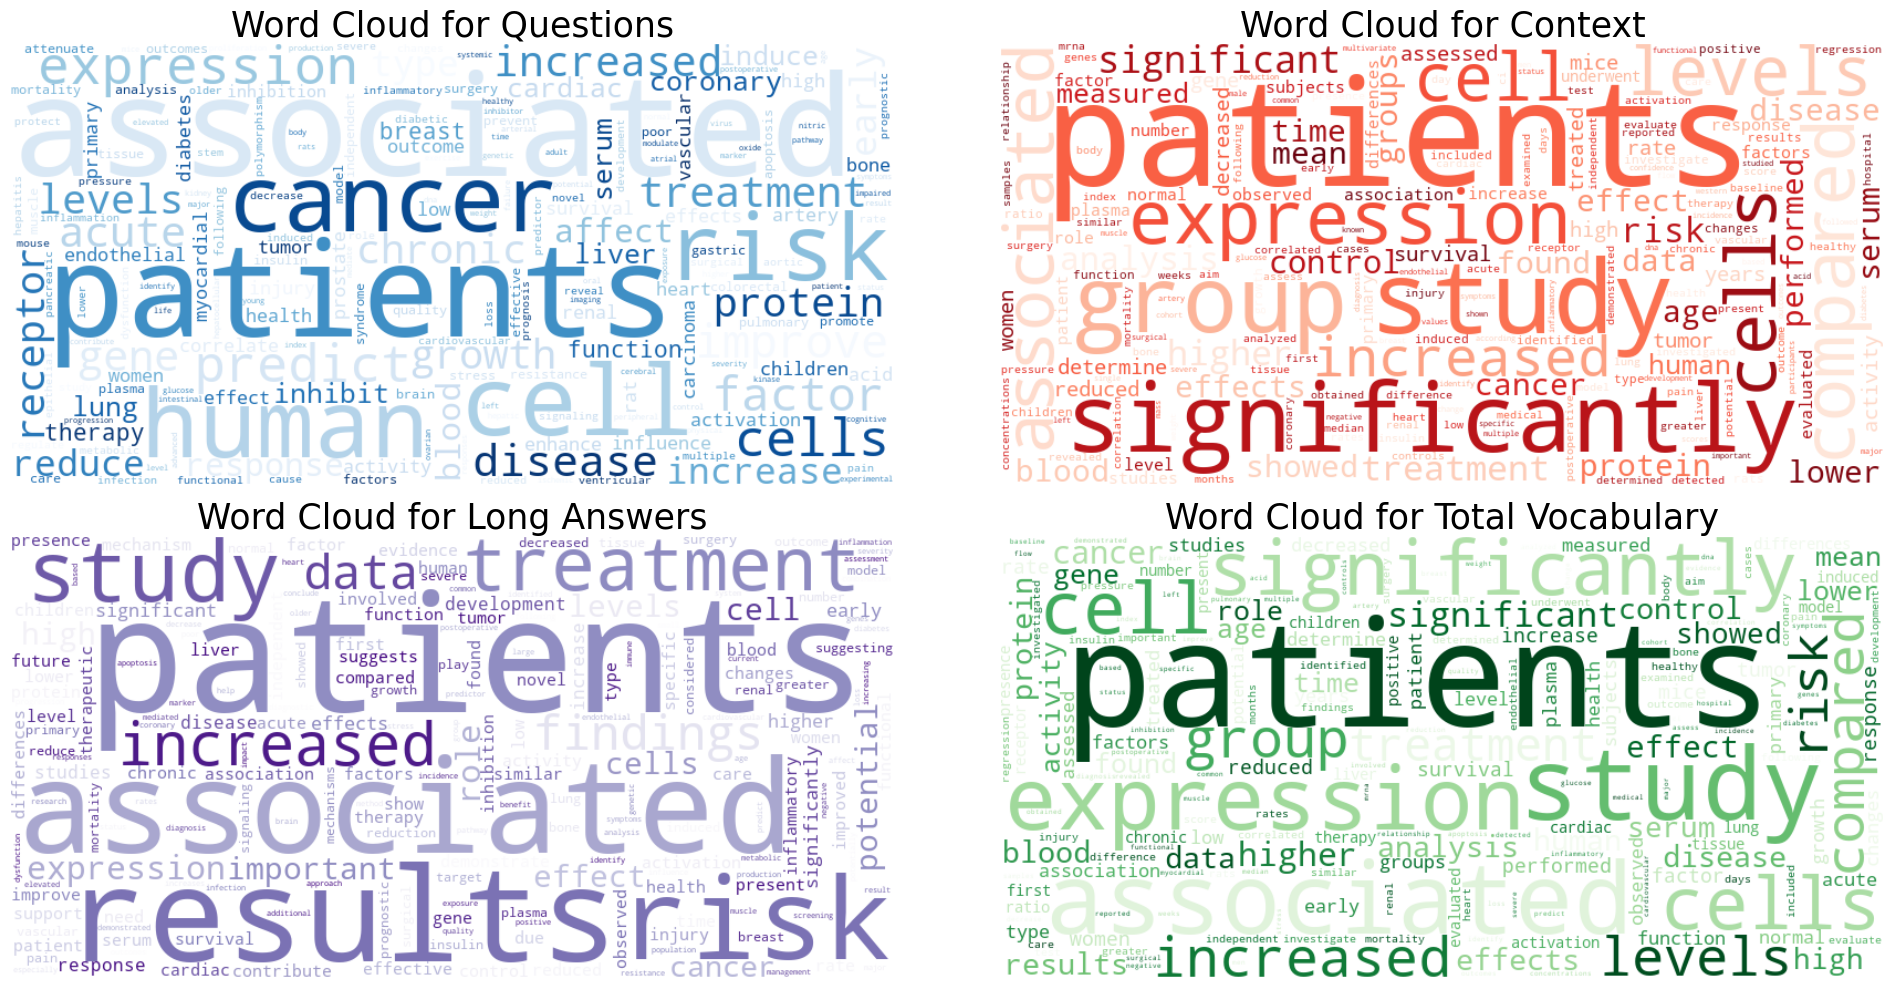

In [24]:
# Now we generate word clouds for the vocabularies of the three features: 'question', 'context', and 'long_answer' and for the total vocabulary across all datasets.
# A word cloud is a visual representation of word frequency, where more frequent words appear larger.
# The function 'generate_wordcloud' takes a vocabulary counter (a dictionary of word frequencies) and a title for the plot.

vocabs = [
    (total_vocab_question, "Questions", "Blues"),
    (total_vocab_context, "Context", "Reds"),
    (total_vocab_long_answer, "Long Answers", "Purples"),
    (total_vocab, "Total Vocabulary", "Greens")  # Aggiungi questo solo se hai total_vocab_total
]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for ax, (vocab, title, colormap) in zip(axes.flat, vocabs):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate_from_frequencies(vocab)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Word Cloud for {title}", fontsize=25)
    ax.axis('off')

plt.tight_layout()
plt.show()


## Clustering Based on TF-IDF Representations

In this section, we explore the thematic structure of the dataset using unsupervised clustering methods based on TF-IDF representations.
Although it is known that TF-IDF representations often yield sparse high-dimensional vectors that challenge traditional clustering methods, we included this analysis to test whether coarse or fine-grained clusters might still reveal latent thematic structure.

We began by computing TF-IDF vectors for each of the main textual features in the dataset: the **question**, **context**, and **long answer**, as well as for the **full preprocessed text**, which combines all three components. The preprocessing pipeline included lowercasing, lemmatization, and the removal of common clinical stopwords, in order to reduce noise and highlight more informative terms.

To estimate the optimal number of clusters for KMeans clustering, we applied the **Elbow Method**, which evaluates the model's inertia (within-cluster sum of squares) across a range of cluster numbers. However, no clear inflection point ("elbow") was observed in the distortion curves, suggesting that the dataset may not exhibit a strong natural clustering structure under this representation.

Despite this, we proceeded to run KMeans clustering with:
- **k = 5**, to test a low number of coarse-grained clusters,
- **k = 30**, to test a finer-grained partitioning of the data.

We then evaluated the **silhouette score** in both cases, which remained consistently low. This result aligns with expectations, since TF-IDF vectors in high-dimensional sparse spaces often do not form well-separated spherical clusters, especially when applied to heterogeneous biomedical texts covering overlapping or nuanced topics.

We also included a **3D visualization** of the clusters using dimensionality reduction (using t-SNE), which further illustrated the absence of compact, clearly separated groupings in the TF-IDF space.

### Conclusions

Our findings confirm that TF-IDF may not be the most effective representation for capturing latent semantic groupings in this dataset, particularly for clustering purposes. The high dimensionality and sparsity, combined with the overlapping nature of medical topics, lead to poor cluster separation. The low silhouette scores confirmed the expected difficulty of achieving well-separated clusters in this domain. <br>
This reinforces the idea that more semantically-aware embeddings (like BioBERT, ClinicalBERT and PubMedBERT, which will be further investigated in the "Embedding techniques" section) may be better suited for unsupervised analysis such as clustering or topic modeling in the biomedical domain.

### Preprocessing
Note that we designed different preprocessing strategies tailored to each task. For future steps such as embedding models like Word2Vec, we preserved sentence structure and token granularity, while for classification tasks we used a simplified approach with a custom stopword list to retain important clinical terms.

In [25]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Removing Stopwords: we changed list to keep valuable indicators such as "no" or "may"
    with open("clinical-stopwords-prepro.txt", "r", encoding="utf-8") as f:
        stop_words = set(line.strip().lower() for line in f if line.strip())

    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lemmatized_tokens)

In [26]:
df_unlabeled['question_lemm'] = df_unlabeled['question'].apply(preprocess_text)
df_unlabeled['context_text'] = df_unlabeled['context'].apply(
    lambda c: " ".join(c['contexts']) if isinstance(c, dict) and 'contexts' in c else ""
)
df_unlabeled['context_lemm'] = df_unlabeled['context_text'].apply(preprocess_text)
df_unlabeled['long_answer_lemm'] = df_unlabeled['long_answer'].apply(preprocess_text)

In [28]:
# Create TF-IDF vectorizers for each feature in the unlabeled dataset in order to perform clustering and similarity analysis.

vectorizer_q = TfidfVectorizer(max_df=0.5, min_df=5)
X_Q_tfidf_U = vectorizer_q.fit_transform(df_unlabeled['question_lemm'])

vectorizer_c = TfidfVectorizer(max_df=0.5, min_df=5)
X_C_tfidf_U = vectorizer_c.fit_transform(df_unlabeled['context_lemm'])

vectorizer_la = TfidfVectorizer(max_df=0.5, min_df=5)
X_LA_tfidf_U = vectorizer_la.fit_transform(df_unlabeled['long_answer_lemm'])

df_unlabeled['full_text_lemm'] = (
    df_unlabeled['question_lemm'] + ' ' +
    df_unlabeled['context_lemm'] + ' ' +
    df_unlabeled['long_answer_lemm']
)
vectorizer_fulltext = TfidfVectorizer(max_df=0.5, min_df=5)
X_fulltext_U = vectorizer_fulltext.fit_transform(df_unlabeled['full_text_lemm'])

### Extensive analysis using Elbow Method

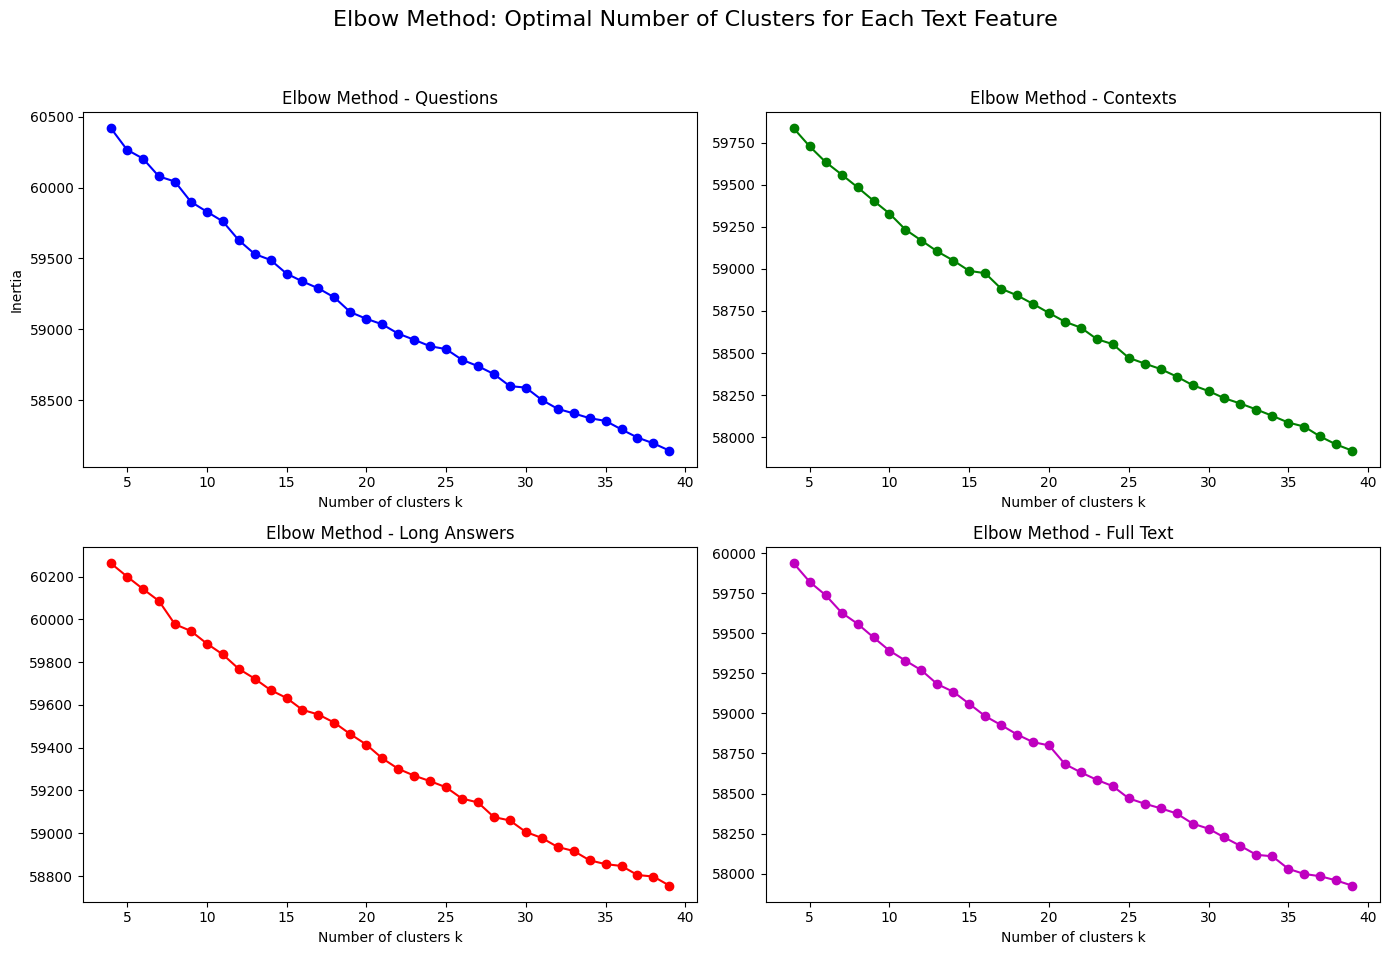

In [29]:
# We apply the Elbow Method to identify the optimal number of clusters (k) for KMeans clustering. 
# This is done separately for three different text features: questions, contexts, and long answers.
 
# The Elbow Method helps us find the value of k where adding more clusters doesn't significantly reduce the inertia 
# (i.e., the sum of squared distances from each point to its assigned cluster center), 
# indicating a good trade-off between model complexity and performance.

# The range of k values to test is set from 2 to 40.
K = range(4, 40)

# Function to compute distortions (inertia) for different values of k
# for a given TF-IDF matrix X. It fits KMeans clustering for each k and appends the inertia to a list.
def compute_distortions(X):
    distortions = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    return distortions

# Compute distortions for each feature in the unlabeled dataset (which we are going to use to perform clustering).
distortion_Q = compute_distortions(X_Q_tfidf_U)
distortion_C = compute_distortions(X_C_tfidf_U)
distortion_LA = compute_distortions(X_LA_tfidf_U)
distortion_Full = compute_distortions(X_fulltext_U)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(K, distortion_Q, 'bo-')
axes[0, 0].set_title("Elbow Method - Questions")
axes[0, 0].set_xlabel("Number of clusters k")
axes[0, 0].set_ylabel("Inertia")

axes[0, 1].plot(K, distortion_C, 'go-')
axes[0, 1].set_title("Elbow Method - Contexts")
axes[0, 1].set_xlabel("Number of clusters k")

axes[1, 0].plot(K, distortion_LA, 'ro-')
axes[1, 0].set_title("Elbow Method - Long Answers")
axes[1, 0].set_xlabel("Number of clusters k")

axes[1, 1].plot(K, distortion_Full, 'mo-')
axes[1, 1].set_title("Elbow Method - Full Text")
axes[1, 1].set_xlabel("Number of clusters k")

plt.suptitle("Elbow Method: Optimal Number of Clusters for Each Text Feature", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In this extended analysis using the Elbow method up to k=40 no clear inflection point was identified (the inertia decreased relatively steadily and linearly), suggesting that there is no naturally optimal number of clusters in the dataset.

Considering this factor, and in order to avoid computationally expensive tuning (e.g., slow grid search),
we arbitrarily chose k=5 as the number of clusters for each of the four TF-IDF representations
(question, context, long_answer), to maintain consistency and enable comparative analysis.

This is therefore an exploratory choice: clustering is still performed to analyze the data distribution,
with the understanding that the dataset might not be particularly well-suited for this type of clustering.

### Clustering with k = 5

In [30]:
k = 5
# Questions
kmeans_Q = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_question_kmeans'] = kmeans_Q.fit_predict(X_Q_tfidf_U)

# Context
kmeans_C = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_context_kmeans'] = kmeans_C.fit_predict(X_C_tfidf_U)

# Long answer
kmeans_LA = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_long_answer_kmeans'] = kmeans_LA.fit_predict(X_LA_tfidf_U)

# Full text
kmeans_FT = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_full_text_kmeans'] = kmeans_LA.fit_predict(X_fulltext_U)

In [ ]:
# Print the most significant word for each cluster in the question feature

terms_q = vectorizer_q.get_feature_names_out()
cluster_keywords_Q = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_question_kmeans'] == cluster_num)[0]
    cluster_tfidf = X_Q_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_Q[cluster_num] = terms_q[keyword_idx]

print(f"The most representative words for each cluster in the question feature are: ", {str(cluster_keywords_Q)})

The most representative words for each cluster in the question feature are:  {"{0: 'level', 1: 'risk', 2: 'cancer', 3: 'care', 4: 'patient'}"}


In [32]:
# Print the most significant word for each cluster in the context feature

terms_c = vectorizer_c.get_feature_names_out()
cluster_keywords_C = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_context_kmeans'] == cluster_num)[0]
    cluster_tfidf = X_C_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_C[cluster_num] = terms_c[keyword_idx]

print(f"The most representative words for each cluster in the context feature are: ", {str(cluster_keywords_C)})

The most representative words for each cluster in the context feature are:  {"{0: 'woman', 1: 'cancer', 2: 'health', 3: 'case', 4: 'group'}"}


In [33]:
# Print the most significant word for each cluster in the long_answer feature

terms_la = vectorizer_la.get_feature_names_out()
cluster_keywords_LA = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_long_answer_kmeans'] == cluster_num)[0]
    cluster_tfidf = X_LA_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_LA[cluster_num] = terms_la[keyword_idx]

print(f"The most representative words for each cluster in the long_answers feature are: ", {str(cluster_keywords_LA)})

The most representative words for each cluster in the long_answers feature are:  {"{0: 'no', 1: 'patient', 2: 'health', 3: 'risk', 4: 'not'}"}


In [36]:
# Print the most significant word for each cluster obtained from the full text

terms_full = vectorizer_fulltext.get_feature_names_out()
cluster_keywords_FT = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_full_text_kmeans'] == cluster_num)[0]
    cluster_tfidf = X_fulltext_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_FT[cluster_num] = terms_full[keyword_idx]

print(f"The most representative words for each cluster in the full text feature are: ", {str(cluster_keywords_FT)})

The most representative words for each cluster in the full text feature are:  {"{0: 'woman', 1: 'cancer', 2: 'group', 3: 'health', 4: 'group'}"}


#### Silhouette Scores: 

In [37]:
print("Intrinsic evaluation for clustering on questions:")
print(" ")
print("Silhouette Score for the Question feature:", silhouette_score(X_Q_tfidf_U, df_unlabeled['cluster_question_kmeans']))
print(" ")
print("Silhouette Score for the Context feature:", silhouette_score(X_C_tfidf_U, df_unlabeled['cluster_context_kmeans']))
print(" ")
print("Silhouette Score for the Long Answer feature:", silhouette_score(X_LA_tfidf_U, df_unlabeled['cluster_long_answer_kmeans']))
print(" ")
print("Silhouette Score for the Long Answer feature:", silhouette_score(X_fulltext_U, df_unlabeled['cluster_full_text_kmeans']))

Intrinsic evaluation for clustering on questions:
 
Silhouette Score for the Question feature: 0.003572031691308183
 
Silhouette Score for the Context feature: 0.002384007421255444
 
Silhouette Score for the Long Answer feature: 0.0019030510521233512
 
Silhouette Score for the Long Answer feature: 0.0028975514856251572


The results are coherent with the fact that silhouette scores obtained from TF-IDF-based clustering are typically low. <br>
This is expected due to the high dimensionality and sparsity of TF-IDF vectors, which can hinder the performance of distance-based clustering algorithms like KMeans. <br>
TF-IDF does not capture semantic similarity well, and many text vectors end up nearly orthogonal, leading to low intra-cluster cohesion and unclear inter-cluster separation.


#### Visualization

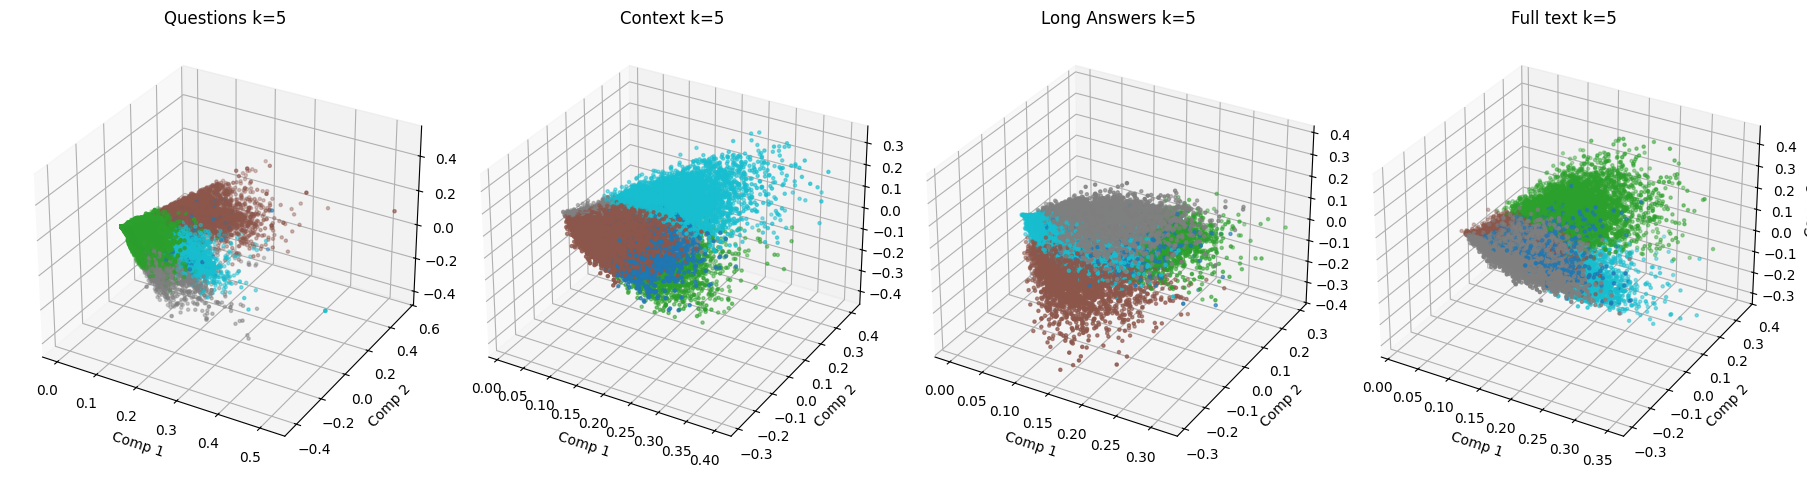

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_svd_3d(X_tfidf):
    svd = TruncatedSVD(n_components=3, random_state=42)
    return svd.fit_transform(X_tfidf)

# Dimensional Reduction
X_Q_reduced = get_svd_3d(X_Q_tfidf_U)
X_C_reduced = get_svd_3d(X_C_tfidf_U)
X_LA_reduced = get_svd_3d(X_LA_tfidf_U)
X_fulltext_reduced = get_svd_3d(X_fulltext_U)

# Subplots
fig = plt.figure(figsize=(18, 5))

# Question Plot
ax1 = fig.add_subplot(141, projection='3d')
ax1.scatter(X_Q_reduced[:, 0], X_Q_reduced[:, 1], X_Q_reduced[:, 2], 
            c=df_unlabeled['cluster_question_kmeans'], cmap='tab10', s=5)
ax1.set_title("Questions k=5")
ax1.set_xlabel("Comp 1")
ax1.set_ylabel("Comp 2")
ax1.set_zlabel("Comp 3")

# Context Plot
ax2 = fig.add_subplot(142, projection='3d')
ax2.scatter(X_C_reduced[:, 0], X_C_reduced[:, 1], X_C_reduced[:, 2], 
            c=df_unlabeled['cluster_context_kmeans'], cmap='tab10', s=5)
ax2.set_title("Context k=5")
ax2.set_xlabel("Comp 1")
ax2.set_ylabel("Comp 2")
ax2.set_zlabel("Comp 3")

# Long Answer Plot
ax3 = fig.add_subplot(143, projection='3d')
ax3.scatter(X_LA_reduced[:, 0], X_LA_reduced[:, 1], X_LA_reduced[:, 2], 
            c=df_unlabeled['cluster_long_answer_kmeans'], cmap='tab10', s=5)
ax3.set_title("Long Answers k=5")
ax3.set_xlabel("Comp 1")
ax3.set_ylabel("Comp 2")
ax3.set_zlabel("Comp 3")

ax4 = fig.add_subplot(144, projection='3d')
ax4.scatter(X_fulltext_reduced[:, 0], X_fulltext_reduced[:, 1], X_fulltext_reduced[:, 2], 
            c=df_unlabeled['cluster_full_text_kmeans'], cmap='tab10', s=5)
ax4.set_title("Full text k=5")
ax4.set_xlabel("Comp 1")
ax4.set_ylabel("Comp 2")
ax4.set_zlabel("Comp 3")

plt.tight_layout()
plt.show()

### Clustering with k = 30

To demonstrate the inconsistency of KMeans clustering, we repeat the process using a larger number of clusters (k=30). <br>
This allows us to check whether increasing the number of clusters leads to a significant improvement in the silhouette score. <br>
If the silhouette score does not improve substantially, it suggests that the clustering is not capturing meaningful structure in the data.


In [39]:
k = 30

# Question
kmeans_Q_30 = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_question_kmeans_30'] = kmeans_Q_30.fit_predict(X_Q_tfidf_U)

# Context
kmeans_C_30 = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_context_kmeans_30'] = kmeans_C_30.fit_predict(X_C_tfidf_U)

# Long answer
kmeans_LA_30 = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_long_answer_kmeans_30'] = kmeans_LA_30.fit_predict(X_LA_tfidf_U)

# Full text
kmeans_FT_30 = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_full_text_kmeans_30'] = kmeans_FT_30.fit_predict(X_fulltext_U)

The silhouette scores remain close to zero for all features (questions, context, long answers, and full text), indicating that increasing the number of clusters does not lead to significantly better-defined or more coherent clusters. <br> 
This further confirms that the data does not naturally separate well into distinct groups using KMeans.

In [42]:
terms_q = vectorizer_q.get_feature_names_out()
cluster_keywords_Q_30 = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_question_kmeans_30'] == cluster_num)[0]
    cluster_tfidf = X_Q_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_Q_30[cluster_num] = terms_q[keyword_idx]

print(f"The most representative words for each cluster in the question feature are: ", {str(cluster_keywords_Q_30)})

The most representative words for each cluster in the question feature are:  {"{0: 'body', 1: 'carcinoma', 2: 'screening', 3: 'artery', 4: 'pain', 5: 'infection', 6: 'time', 7: 'surgery', 8: 'care', 9: 'acute', 10: 'surgical', 11: 'disease', 12: 'predict', 13: 'difference', 14: 'risk', 15: 'pulmonary', 16: 'emergency', 17: 'patient', 18: 'cancer', 19: 'health', 20: 'pregnancy', 21: 'marker', 22: 'gastric', 23: 'pelvic', 24: 'associated', 25: 'aortic', 26: 'therapy', 27: 'safe', 28: 'rate', 29: 'child'}"}


In [43]:
terms_c = vectorizer_c.get_feature_names_out()
cluster_keywords_C_30 = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_context_kmeans_30'] == cluster_num)[0]
    cluster_tfidf = X_C_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_C_30[cluster_num] = terms_c[keyword_idx]

print(f"The most representative words for each cluster in the context feature are: ", {str(cluster_keywords_C_30)})

The most representative words for each cluster in the context feature are:  {"{0: 'bmi', 1: 'cancer', 2: 'coronary', 3: 'prostate', 4: 'pain', 5: 'level', 6: 'depression', 7: 'practice', 8: 'hospital', 9: 'pressure', 10: 'diabetes', 11: 'group', 12: 'tumor', 13: 'stroke', 14: 'ci', 15: 'test', 16: 'survival', 17: 'lesion', 18: 'injury', 19: 'month', 20: 'fracture', 21: 'woman', 22: 'child', 23: 'health', 24: 'physician', 25: 'birth', 26: 'student', 27: 'hiv', 28: 'ct', 29: 'cell'}"}


In [44]:
terms_la = vectorizer_la.get_feature_names_out()
cluster_keywords_LA_30 = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_long_answer_kmeans_30'] == cluster_num)[0]
    cluster_tfidf = X_LA_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_LA_30[cluster_num] = terms_la[keyword_idx]

print(f"The most representative words for each cluster in the long_answers feature are: ", {str(cluster_keywords_LA_30)})

The most representative words for each cluster in the long_answers feature are:  {"{0: 'insulin', 1: 'cancer', 2: 'quality', 3: 'diagnosis', 4: 'clinical', 5: 'breast', 6: 'health', 7: 'level', 8: 'association', 9: 'node', 10: 'tumor', 11: 'surgery', 12: 'child', 13: 'blood', 14: 'pain', 15: 'procedure', 16: 'patient', 17: 'woman', 18: 'care', 19: 'stroke', 20: 'risk', 21: 'rate', 22: 'training', 23: 'result', 24: 'not', 25: 'effect', 26: 'injury', 27: 'treatment', 28: 'outcome', 29: 'student'}"}


In [45]:
terms_FT = vectorizer_fulltext.get_feature_names_out()
cluster_keywords_FT_30 = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_full_text_kmeans_30'] == cluster_num)[0]
    cluster_tfidf = X_fulltext_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_FT_30[cluster_num] = terms_FT[keyword_idx]

print(f"The most representative words for each cluster in the long_answers feature are: ", {str(cluster_keywords_FT_30)})

The most representative words for each cluster in the long_answers feature are:  {"{0: 'bmi', 1: 'cancer', 2: 'depression', 3: 'coronary', 4: 'liver', 5: 'fracture', 6: 'aortic', 7: 'level', 8: 'injury', 9: 'student', 10: 'hospital', 11: 'smoking', 12: 'ct', 13: 'mortality', 14: 'pain', 15: 'lung', 16: 'case', 17: 'treatment', 18: 'stroke', 19: 'survival', 20: 'health', 21: 'node', 22: 'child', 23: 'af', 24: 'surgery', 25: 'pregnancy', 26: 'stone', 27: 'group', 28: 'hiv', 29: 'cognitive'}"}


#### Silhouette Scores:

In [46]:
print("Intrinsic evaluation for clustering on questions:")
print(" ")
print("Silhouette Score for the Question feature:", silhouette_score(X_Q_tfidf_U, df_unlabeled['cluster_question_kmeans_30']))
print(" ")
print("Silhouette Score for the Context feature:", silhouette_score(X_C_tfidf_U, df_unlabeled['cluster_context_kmeans_30']))
print(" ")
print("Silhouette Score for the Long Answer feature:", silhouette_score(X_LA_tfidf_U, df_unlabeled['cluster_long_answer_kmeans_30']))
print(" ")
print("Silhouette Score for the full text:", silhouette_score(X_fulltext_U, df_unlabeled['cluster_full_text_kmeans_30']))

Intrinsic evaluation for clustering on questions:
 
Silhouette Score for the Question feature: 0.011363579411848724
 
Silhouette Score for the Context feature: 0.006322112972368833
 
Silhouette Score for the Long Answer feature: 0.0061696137595411635
 
Silhouette Score for the full text: 0.007486801019776665


#### Visualization:

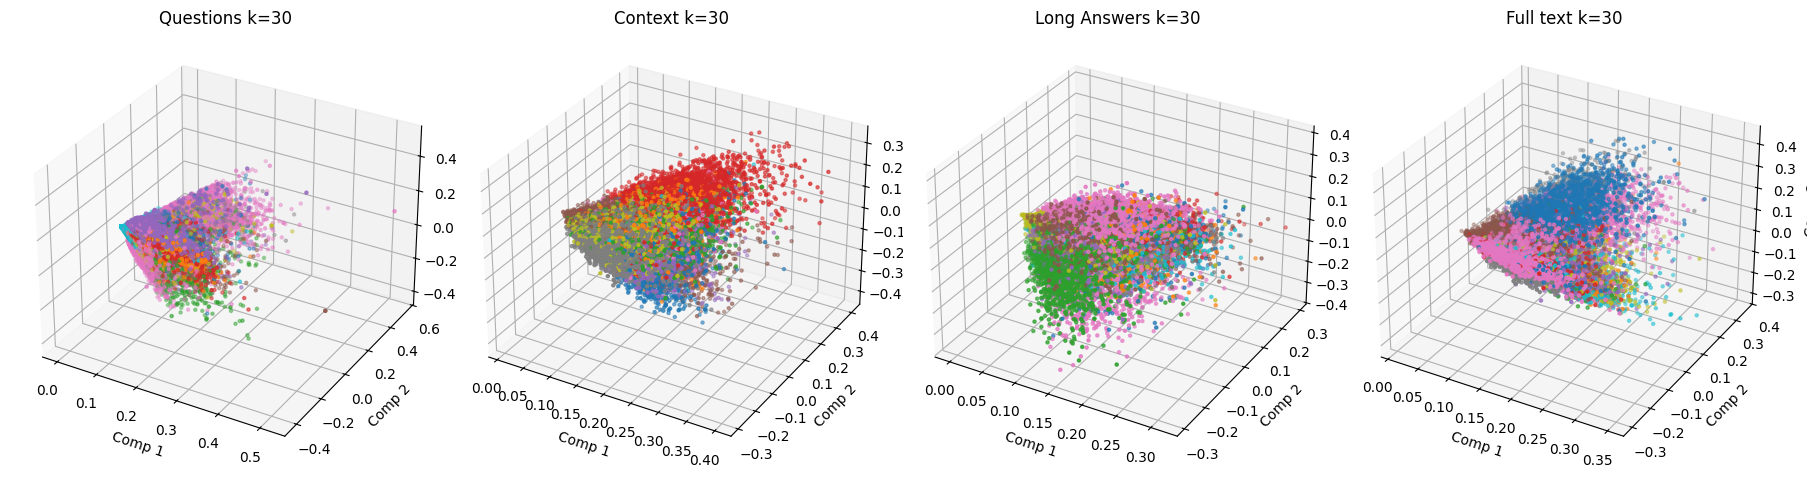

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Subplots
fig = plt.figure(figsize=(18, 5))

# Question Plot 
ax1 = fig.add_subplot(141, projection='3d')
ax1.scatter(X_Q_reduced[:, 0], X_Q_reduced[:, 1], X_Q_reduced[:, 2], 
            c=df_unlabeled['cluster_question_kmeans_30'], cmap='tab10', s=5)
ax1.set_title("Questions k=30")
ax1.set_xlabel("Comp 1")
ax1.set_ylabel("Comp 2")
ax1.set_zlabel("Comp 3")

# Context Plot 
ax2 = fig.add_subplot(142, projection='3d')
ax2.scatter(X_C_reduced[:, 0], X_C_reduced[:, 1], X_C_reduced[:, 2], 
            c=df_unlabeled['cluster_context_kmeans_30'], cmap='tab10', s=5)
ax2.set_title("Context k=30")
ax2.set_xlabel("Comp 1")
ax2.set_ylabel("Comp 2")
ax2.set_zlabel("Comp 3")

# Long Answer Plot 
ax3 = fig.add_subplot(143, projection='3d')
ax3.scatter(X_LA_reduced[:, 0], X_LA_reduced[:, 1], X_LA_reduced[:, 2], 
            c=df_unlabeled['cluster_long_answer_kmeans_30'], cmap='tab10', s=5)
ax3.set_title("Long Answers k=30")
ax3.set_xlabel("Comp 1")
ax3.set_ylabel("Comp 2")
ax3.set_zlabel("Comp 3")

ax4 = fig.add_subplot(144, projection='3d')
ax4.scatter(X_fulltext_reduced[:, 0], X_fulltext_reduced[:, 1], X_fulltext_reduced[:, 2], 
            c=df_unlabeled['cluster_full_text_kmeans_30'], cmap='tab10', s=5)
ax4.set_title("Full text k=30")
ax4.set_xlabel("Comp 1")
ax4.set_ylabel("Comp 2")
ax4.set_zlabel("Comp 3")


plt.tight_layout()
plt.show()

## Topic Modeling with LDA

In this section, we explore the latent thematic structure of the dataset using **Latent Dirichlet Allocation (LDA)**, a widely used probabilistic topic modeling algorithm. Our analysis is based on the **TF-IDF representation** of the full preprocessed text, which includes the question, context, and long answer fields. The preprocessing involved lowercasing, lemmatization, and removal of common clinical stopwords to emphasize content-bearing terms.

We first split the **unlabeled dataset** into a training and test set. The LDA model was trained on the training portion using **TF-IDF vectors** as input, even though traditional LDA is typically applied on raw term frequencies. We chose to use TF-IDF to downweight overly common terms while retaining a sparse, interpretable representation.

To determine the number of topics (`n_components`) and training iterations (`max_iter`), we experimented with various combinations and evaluated their impact on model performance using the **perplexity score**. The final configuration was selected based on the **best trade-off between model quality and computational cost**.

After training, we:
- Evaluated model generalization on the **test set**, where the perplexity score provided a quantitative measure of how well the model captured the underlying data distribution.
- **Inspected the top words for each topic**, giving a qualitative insight into the dominant themes identified by the model.
- **Tested topic coherence** by examining the dominant topics assigned to a specific document in the test set, confirming that the topic distribution aligned with the document's content.
- Finally, we generated a **3D t-SNE visualization** of the dominant topics across documents, enabling us to visually assess how well the model clustered documents into coherent topic regions in reduced space.

This approach allowed us to gain an interpretable, unsupervised overview of the main themes within our dataset, even if TF-IDF may slightly distort topic proportions compared to raw counts. Despite this, the results remained meaningful and provided valuable insight into the document collection’s structure.

In [61]:
from sklearn.model_selection import train_test_split

vec_fulltext_train, vec_fulltext_test = train_test_split(df_unlabeled['full_text_lemm'], test_size=0.4)
print('No. training docs:', len(vec_fulltext_train))
print('No. testing docs:', len(vec_fulltext_test))

No. training docs: 36749
No. testing docs: 24500


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization
vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=.8)
vector_documents_train = vectorizer.fit_transform(vec_fulltext_train)

# LDA
lda = LatentDirichletAllocation(n_components=20, verbose=1, learning_method='online', max_iter=40, random_state=42)  
lda.fit(vector_documents_train)

# The number of topics (n_components) and iterations (max_iter) were chosen empirically.
# We tested several combinations, observing how perplexity evolved with each setting while also considering computational time.
# The selected configuration reflects the best trade-off between model performance and efficiency.

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40
iteration: 31 of max_iter: 40
iteration: 32 of max_iter: 40
iteration: 33 of max_iter: 40
iteration: 34 of ma

LatentDirichletAllocation(learning_method='online', max_iter=40,
                          n_components=20, random_state=42, verbose=1)

In [ ]:
# Performance evaluation of topic modeling on the test set

vector_documents_test = vectorizer.transform(vec_fulltext_test)
perplexity_fulltext = lda.perplexity(vector_documents_test)
print(f"The Perplexity of the lda model is: ", {str(lda.perplexity(vector_documents_test))})

# The perplexity score of the LDA model on the test set is approximately 2338.
# Perplexity measures how well the model predicts a sample; lower values indicate better generalization.
# However, perplexity is not always aligned with human interpretability of topics and can be difficult to assess directly.
# A relatively high perplexity (as observed here) may indicate that the model struggles to capture coherent topic structures,
# especially when using TF-IDF vectors instead of raw term frequencies, which can distort the true word distributions.

The Perplexity of the lda model is:  {'2338.126436827061'}


In [ ]:
vocab = vectorizer.get_feature_names_out()

# Print the most important words for each topic
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    top_words = [vocab[idx] for idx in sorted_terms[:10]]
    concatenated_terms = '[' + ', '.join(top_words) + ']'
    print(f'Topic {i + 1}:\t{concatenated_terms}')

# Below are the top 10 keywords for each of the 20 topics extracted using LDA.
# These keywords provide a high-level summary of the thematic structure discovered in the dataset.
# Many topics clearly correspond to distinct medical subdomains or clinical contexts, such as:
# - Topic 3 (treatment and therapy trials),
# - Topic 6 (oncology and cancer prognosis),
# - Topic 8 (diabetes and metabolic disorders),
# - Topic 15 (public health and healthcare services),
# - Topic 18 (pregnancy and obstetrics).
# This suggests that the LDA model successfully captured meaningful and interpretable themes aligned with common areas of biomedical research.
# However, some topic overlaps (e.g., multiple topics with "patient", "study") reflect the generic nature of clinical reporting.

Topic 1:	[control, effect, muscle, change, human, response, eye, model, tissue, rat]
Topic 2:	[test, score, performance, correlation, value, method, study, clinical, assessment, mean]
Topic 3:	[treatment, patient, therapy, group, infection, drug, trial, study, month, response]
Topic 4:	[level, serum, stroke, concentration, protein, plasma, marker, patient, higher, significantly]
Topic 5:	[group, blood, pressure, mm, mean, difference, bone, knee, study, significant]
Topic 6:	[patient, cancer, tumor, survival, stage, node, metastasis, treatment, recurrence, year]
Topic 7:	[patient, group, surgery, postoperative, year, complication, rate, procedure, month, mean]
Topic 8:	[diabetes, patient, type, hip, glucose, diabetic, acid, insulin, level, resistance]
Topic 9:	[patient, hospital, mortality, outcome, day, ci, risk, rate, year, study]
Topic 10:	[injury, fracture, trauma, ed, repair, child, head, case, nerve, patient]
Topic 11:	[patient, lesion, diagnosis, ct, imaging, clinical, finding, s

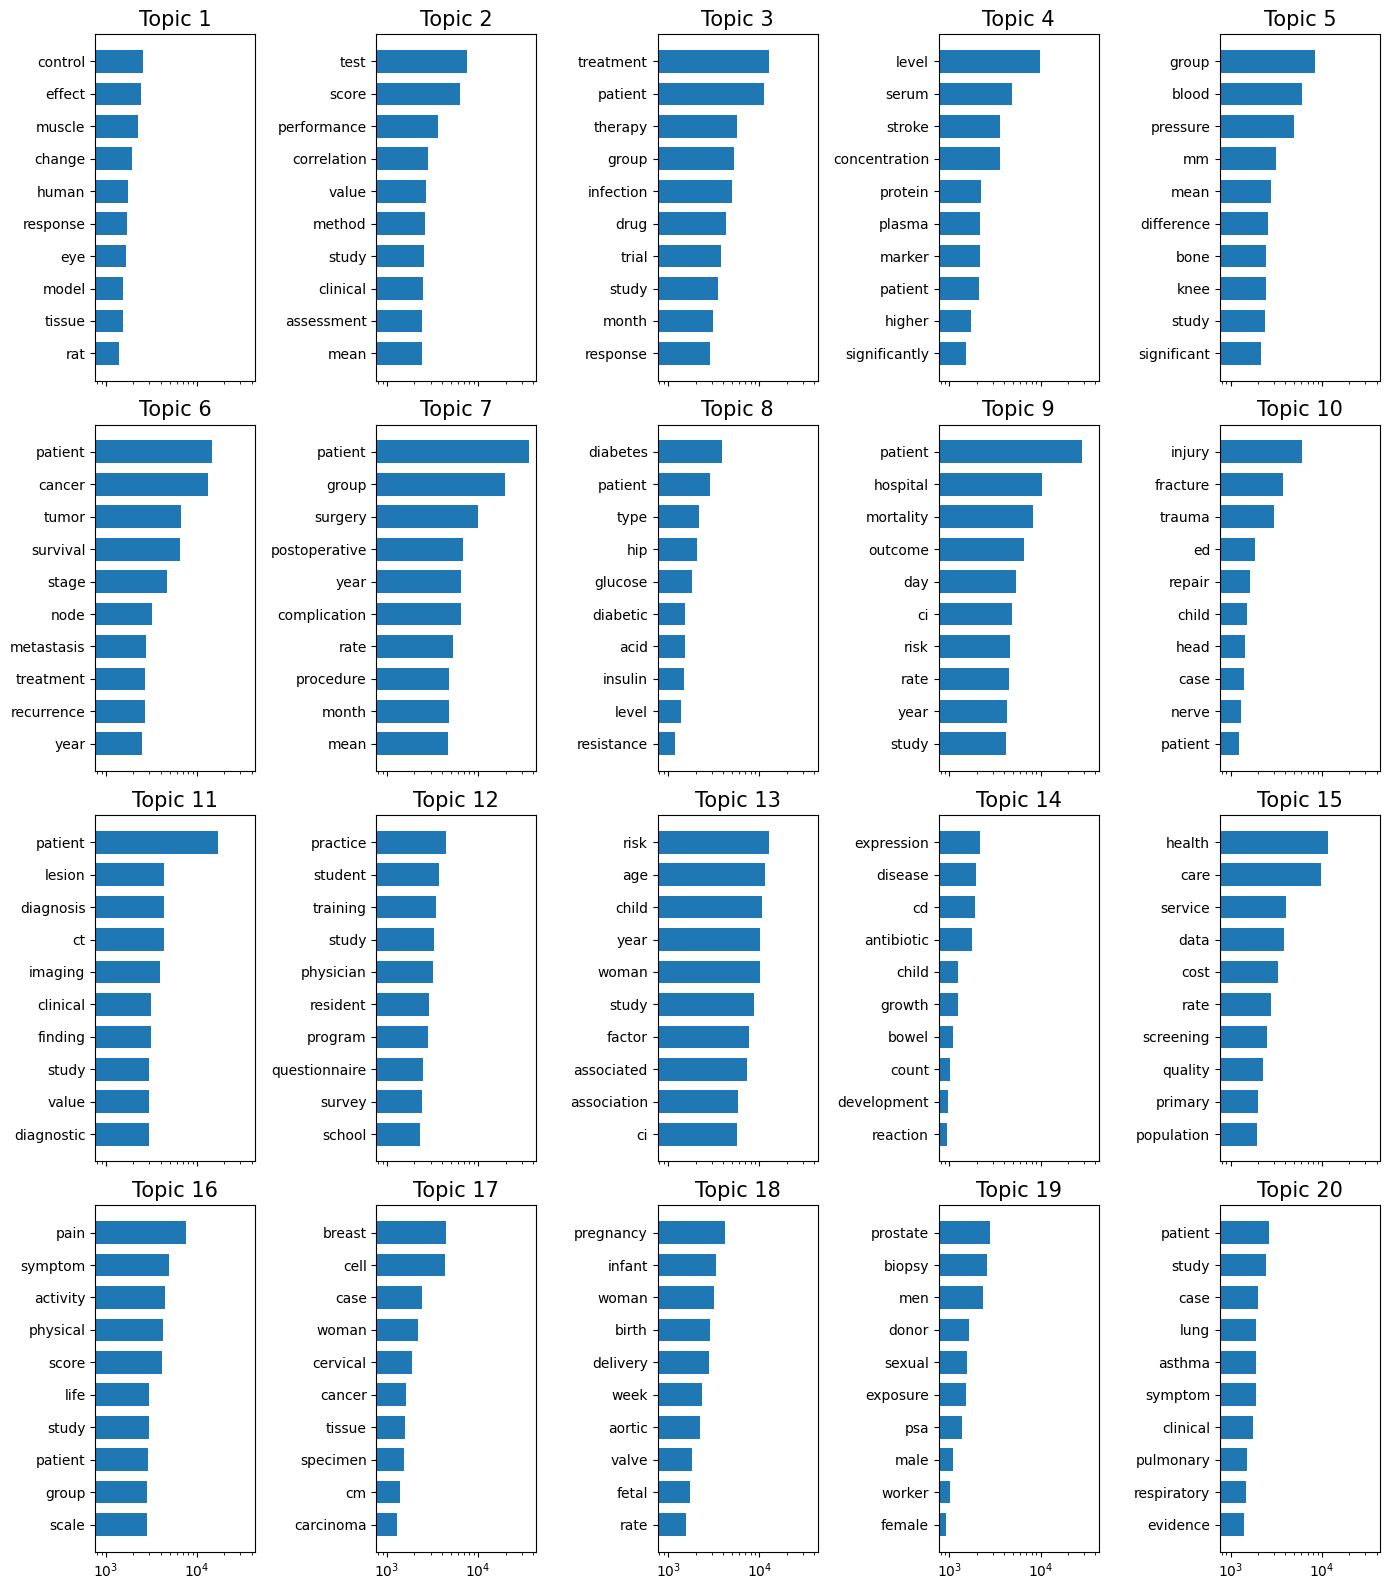

In [65]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Here we test a document in the test set to see if the topic assigned are coherent with the document's content

doc_example = vec_fulltext_test.iloc[1]
print(doc_example)

copd rare disease according literature copd rate high spite decreasing rate risk factor smoking air pollution developed country general practice place survey unbiased prevalence rate study general practice last year found prevalence rate smoker prevalence detection rate copd smoker german general practice twentyeight invited eligible gp surgery inaround duesseldorf germany part nonannounced day investigation smoker year visited surgery lung function test handheld spirometer peak flow sympton part st george respiratory questionnaire data smoking habit gold criterion copd employed gps diagnosis not knowing test result patient attending surgery smoker hundred thirtyseven agreed participate reasonsunacceptable spirometry hundred ninetyeight patient not previously diagnosed copd asthma thirty patient disgnosed copd making prevalence patient known copd result low prevalence differs strongly study general practice study design avoids selection bias found nearly study no preannouncement no sel

In [ ]:
doc_vec_example = vectorizer.transform([doc_example])[0]
topic_vec = lda.transform(doc_vec_example)[0]

In [68]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

In [69]:
for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

23.6% Topic 12: risk age child year woman study factor associated association ci
21.0% Topic 8: patient hospital mortality outcome day ci risk rate year study
15.6% Topic 19: patient study case lung asthma symptom clinical pulmonary respiratory evidence
12.7% Topic 11: practice student training study physician resident program questionnaire survey school
8.7% Topic 15: pain symptom activity physical score life study patient group scale
5.6% Topic 1: test score performance correlation value method study clinical assessment mean
5.3% Topic 10: patient lesion diagnosis ct imaging clinical finding study value diagnostic
5.2% Topic 14: health care service data cost rate screening quality primary population
1.0% Topic 3: level serum stroke concentration protein plasma marker patient higher significantly


In [ ]:
from sklearn.manifold import TSNE

# TSNE transformation on the test set
tsne_embedding_test = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))

# TSNE transformation on the train set
tsne_embedding_train = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_train))

# Check of data shape
print(tsne_embedding_test.shape)
print(tsne_embedding_train.shape)


(24500, 3)
(36749, 3)


In [ ]:
[x_test, y_test, z_test] = np.transpose(tsne_embedding_test)
[x_train, y_train, z_train] = np.transpose(tsne_embedding_train)

In [ ]:
# Transform the documents into their topic distribution format

topic_distributions_test = lda.transform(vector_documents_test)
topic_distributions_train = lda.transform(vector_documents_train)

# Now `topic_distributions` is a matrix of shape (num_documents, num_topics),
# where each row represents a document and each column contains the probability of that topic in the document

In [ ]:
# Get the topic with the highest probability for each document

dominant_topics_train = topic_distributions_train.argmax(axis=1)
dominant_topics_test = topic_distributions_test.argmax(axis=1)

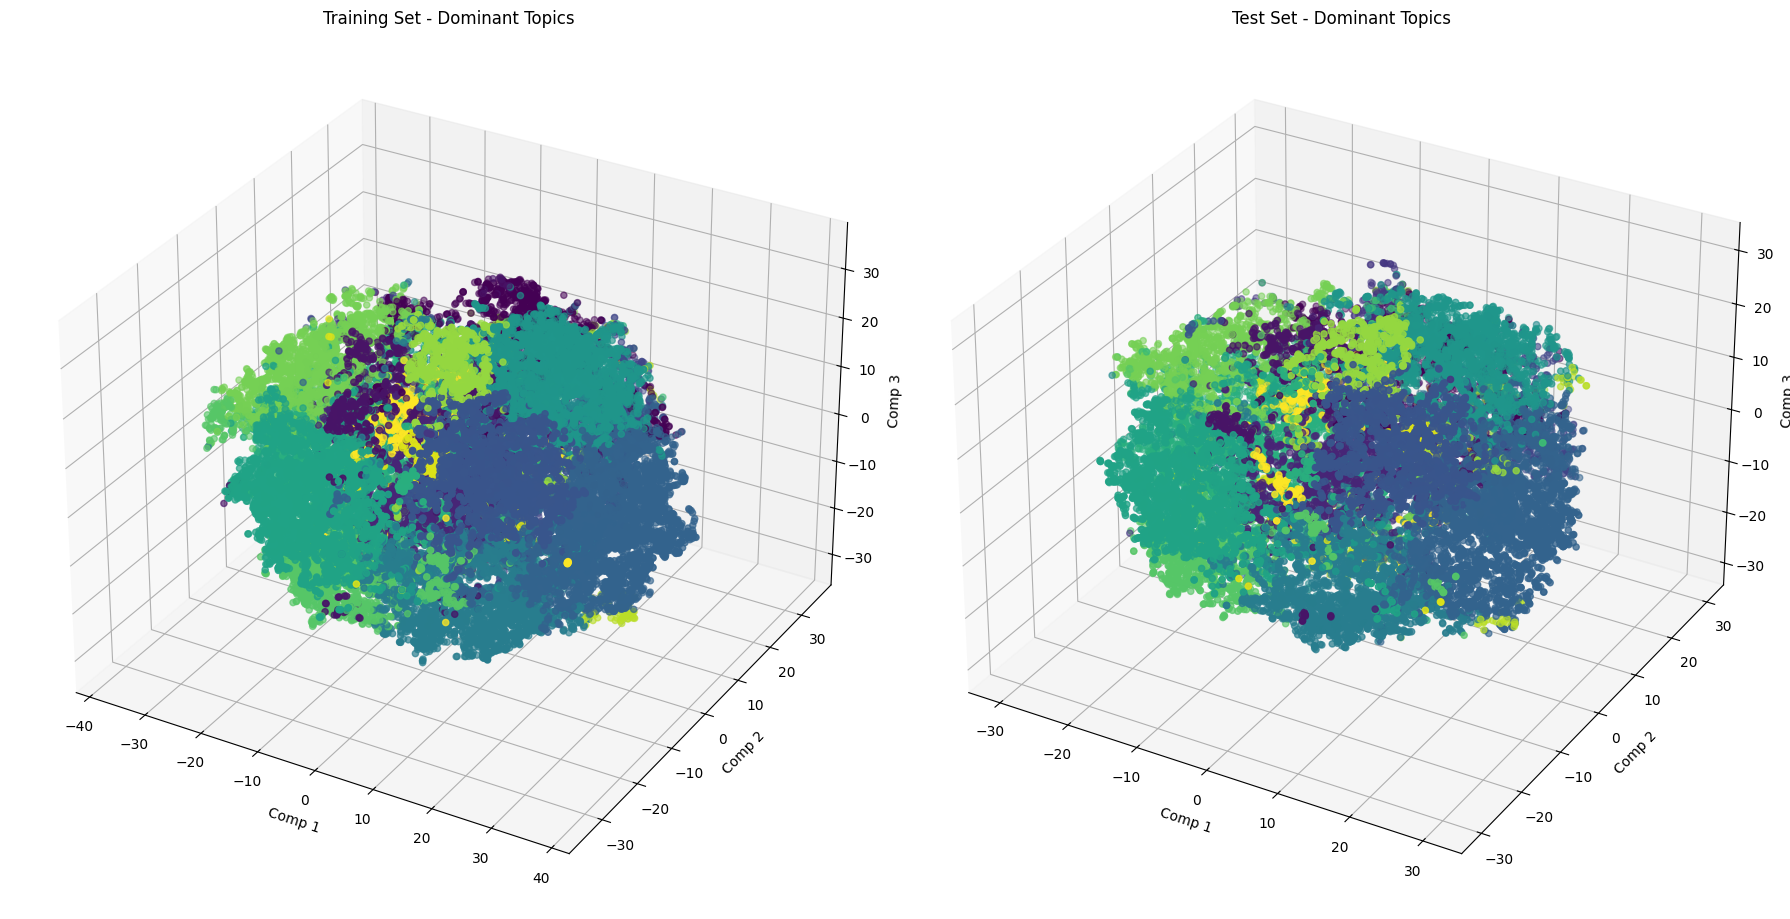

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Crea la figura
fig = plt.figure(figsize=(18, 10))

# Plot per il training set
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_train, y_train, z_train,
            c=dominant_topics_train)
ax1.set_title("Training Set - Dominant Topics")
ax1.set_xlabel("Comp 1")
ax1.set_ylabel("Comp 2")
ax1.set_zlabel("Comp 3")

# Plot per il test set
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_test, y_test, z_test, 
            c=dominant_topics_test)
ax2.set_title("Test Set - Dominant Topics")
ax2.set_xlabel("Comp 1")
ax2.set_ylabel("Comp 2")
ax2.set_zlabel("Comp 3")


plt.tight_layout()
plt.show()


## Word2Vec Embedding

In [1]:
# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 1. Preprocessing per documento -> frasi -> token lemmatizzati
def preprocess_sentences_embedding(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences

# 2. Applichiamo il preprocessing al DataFrame
#'context_text', 'question' e 'long_answer'
all_tokenized_sentences = []
document_token_lists = []

for idx, row in df_unlabeled.iterrows():
    # Uniamo il contenuto delle tre colonne per ogni riga
    combined_text = f"{row['context_text']} {row['question']} {row['long_answer']}"
    
    # Preprocessing sul testo combinato
    tokenized_sentences = preprocess_sentences_embedding(combined_text)
    all_tokenized_sentences.extend(tokenized_sentences)
    
    # Salva tutti i token del documento (flat) per embedding successivo
    flat_tokens = [token for sentence in tokenized_sentences for token in sentence]
    document_token_lists.append(flat_tokens)

df_unlabeled['tokens'] = document_token_lists

# 3. Addestriamo Word2Vec su tutte le frasi tokenizzate
w2v_model = Word2Vec(sentences=all_tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# 4. Creiamo i vettori documento (media dei vettori delle parole)
def document_vector(doc_tokens):
    valid_tokens = [token for token in doc_tokens if token in w2v_model.wv]
    if not valid_tokens:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[valid_tokens], axis=0)

df_unlabeled['vector_embedding_w2v'] = df_unlabeled['tokens'].apply(document_vector)



NameError: name 'stopwords' is not defined

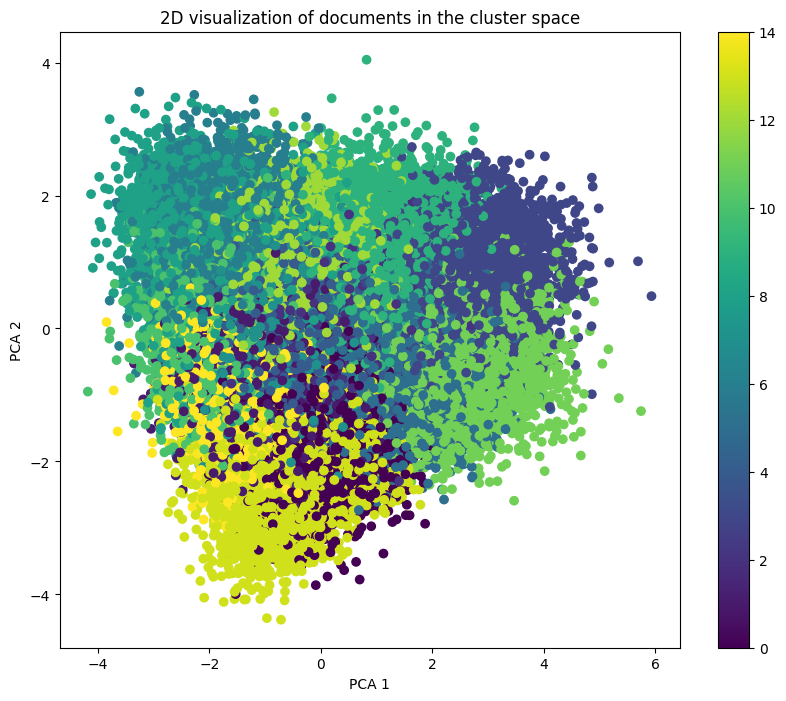

Cluster 0: mgdl, hbac, baseline, ghtnpreeclampsia, fallor
Cluster 1: bernageaus, displacement, sagittal, valgus, volar
Cluster 2: pregnancy, stillbirth, birth, singleton, primigravida
Cluster 3: gps, psychiatrist, pharmacist, client, responsibility
Cluster 4: definite, patient, none, symptomatic, pancreticoduedenectomy
Cluster 5: psychological, psychosocial, cognitive, individual, emotional
Cluster 6: reoperation, redo, operative, reintervention, surgical
Cluster 7: group, initial, thd, prescriptionsyear, carbimazole
Cluster 8: recurrence, adjuvant, pn, unresected, ilc
Cluster 9: gps, gp, physician, appointment, consultation
Cluster 10: fnac, nondiagnostic, suspicious, mri, indeterminate
Cluster 11: employment, social, socioeconomic, psychosocial, spouse
Cluster 12: inhospital, overall, hospitalization, reoperation, mortality
Cluster 13: chemotaxis, enterocyte, cul, rrg, fibrillar
Cluster 14: lvef, cmsec, lvedp, psv, revascularized


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# RIMETTERLO IN 3D

# 1. Applichiamo K-means sui vettori dei documenti
n_clusters = 15  # Numero di cluster che vuoi generare
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_unlabeled['vector_embedding'].apply(np.array).tolist())  # Usa i vettori dei documenti

# 2. Aggiungi i cluster come colonna nel DataFrame
df_unlabeled['cluster'] = kmeans.labels_

# 3. Visualizza i risultati del clustering (riduzione della dimensionalità per visualizzare)
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(np.vstack(df_unlabeled['vector_embedding'].apply(np.array).tolist()))

# Visualizza i dati proiettati su 2D
plt.figure(figsize=(10, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df_unlabeled['cluster'], cmap='viridis')
plt.colorbar()
plt.title('2D visualization of documents in the cluster space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# 4. Analisi dei centri dei cluster (opzionale, per vedere le parole centrali di ogni cluster)
centroids = kmeans.cluster_centers_

# Trova le parole più vicine ai centri di ciascun cluster
for i, centroid in enumerate(centroids):
    closest_words = w2v_model.wv.similar_by_vector(centroid, topn=5)
    print(f"Cluster {i}: {', '.join([word for word, _ in closest_words])}")

In [ ]:
from sklearn.metrics import silhouette_score

# Ottieni la matrice X dei vettori documento
X_vectors = np.vstack(df_unlabeled['vector_embedding'].apply(np.array).tolist())
labels = df_unlabeled['cluster']

# 1. Silhouette Score
sil_score = silhouette_score(X_vectors, labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.077


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Silhouette Score: 0.014


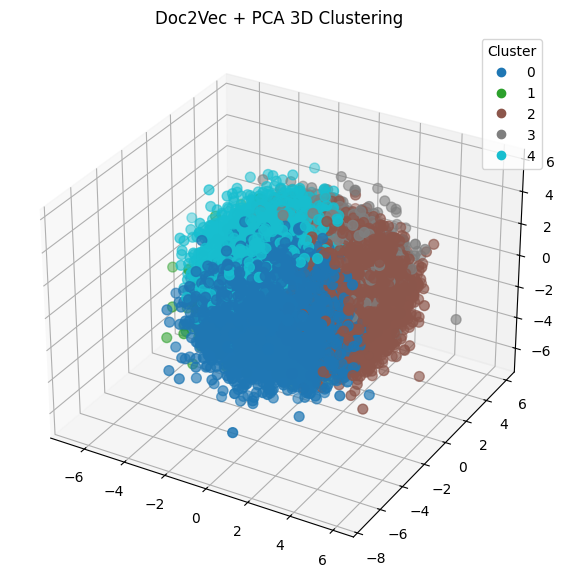

In [ ]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_sentences(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences

# 1. Preprocessing unendo 'context_text', 'question' e 'long_answer'
token_lists = []
for idx, row in df_unlabeled.iterrows():
    combined_text = f"{row['context_text']} {row['question']} {row['long_answer']}"
    tokenized_sentences = preprocess_sentences(combined_text)
    flat_tokens = [token for sentence in tokenized_sentences for token in sentence]
    token_lists.append(flat_tokens)

df_unlabeled['tokens'] = token_lists

# 2. Prepara dati per Doc2Vec
tagged_data = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(df_unlabeled['tokens'])]

# 3. Addestra Doc2Vec
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=40)

# 4. Estrai i vettori documento
doc_vectors = np.array([doc2vec_model.dv[str(i)] for i in range(len(tagged_data))])
df_unlabeled['vector_embedding_d2v'] = list(doc_vectors)



In [ ]:
# 5. Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_unlabeled['cluster'] = kmeans.fit_predict(doc_vectors)

# 6. Silhouette Score
sil_score = silhouette_score(doc_vectors, df_unlabeled['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# 7. Visualizzazione 3D
pca = PCA(n_components=3)
reduced_vecs = pca.fit_transform(doc_vectors)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], reduced_vecs[:, 2],
                     c=df_unlabeled['cluster'], cmap='tab10', s=50)
ax.set_title('Doc2Vec + PCA 3D Clustering')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [ ]:
# DIVIDERE QUESTO CODICE IN CELLE PIù PICCOLE SE NO RUNNA LENTO

import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.fasttext import FastText
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Scarica risorse NLTK se necessario
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_sentences(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences

# 1. Preprocessing unendo 'context_text', 'question' e 'long_answer'
token_lists = []
for idx, row in df_unlabeled.iterrows():
    combined_text = f"{row['context_text']} {row['question']} {row['long_answer']}"
    tokenized_sentences = preprocess_sentences(combined_text)
    flat_tokens = [token for sentence in tokenized_sentences for token in sentence]
    token_lists.append(flat_tokens)

df_unlabeled['tokens'] = token_lists

# 2. Addestra FastText
# Poiché FastText è basato su frasi, dobbiamo unire tutte le frasi in un'unica lista di token
sentences_for_fasttext = df_unlabeled['tokens'].tolist()

fasttext_model = FastText(sentences=sentences_for_fasttext, vector_size=100, window=5, min_count=1, workers=4, epochs=40)

# 3. Estrai i vettori documento
# Calcoliamo i vettori medi di ciascun documento
doc_vectors = np.array([np.mean([fasttext_model.wv[token] for token in tokens if token in fasttext_model.wv], axis=0) 
                       for tokens in df_unlabeled['tokens']])
df_unlabeled['vector_embedding_ft'] = list(doc_vectors)

# 4. Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_unlabeled['cluster'] = kmeans.fit_predict(doc_vectors)

# 5. Silhouette Score
sil_score = silhouette_score(doc_vectors, df_unlabeled['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# 6. Visualizzazione 3D
pca = PCA(n_components=3)
reduced_vecs = pca.fit_transform(doc_vectors)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], reduced_vecs[:, 2],
                     c=df_unlabeled['cluster'], cmap='tab10', s=50)
ax.set_title('FastText + PCA 3D Clustering')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [ ]:
# IN GENERALE:
# abbiamo fatto il wordembedding con fasttext e doc2vec e word2vec e poi abbiamo fatto il clustering con kmeans per vedere se i risultati miglioravano 
# la silouette è migliorata rieptto alla tfidf ma è comunque vicina allo zero, poi useremo gli embedding anche nalla classificazione
# e vediamo se i risultati migliorano

# NB non so se ha senso rifare la cosa dell'elbow method anche per i vettori con embedding per vedere il numero di cluster ottimale,
# per vedere se in generale overall la coesione interna migliora nonostante la silouhette

# Inoltre per adesso il numero di cluster è 5 (15 in word2vec) quindi bisognerebbe fare qualcosa tipo l'elbow per giustificare il numero di cluster e vedere quello ottimale

# FARE LA VISUALIZZAZIONE DEGLI EMBEDDING CHE QUELLA NON L'ABBIAMO FATTA

# SISTEMARE ANCHE LE COLONNE DEGLI EMBEDDING CHE SI CHIAMANO TUTTE VECTOR_EMBEDDING QUINDI OGNI VOLTA SI SOVRASCRIVE
# Dividere i codici in celle un po' più piccole perchè è lentooo

# Second Step: Training models
Each dataset has been created with a particular task in mind. You don’t necessarily need to tackle that
particular problem, but you do need to train some model(s) on the data:
- train ML models (e.g. a linear classifier, an LSTM and/or a Transformer) to perform a particular
task on the data;
- if possible, try to fine-tune a pretrained models on the same task and compare their performance;
- try an LLM on the task, comparing one, few and zero-shot performance;
- and perhaps even try to fine-tune a small LLM on the task (if it makes sense to do so).

## Classification task
### Why we applied PCA and visualized the TF-IDF vectors

To better understand whether the automatically generated (artificial) dataset is suitable for training a classifier to be evaluated on the manually labeled dataset, we applied Principal Component Analysis (PCA) to reduce the high-dimensional TF-IDF vectors into two dimensions. We then plotted the projections for both the *questions* and the *long answers*.

This visual inspection allows us to assess:
- How well the artificial and labeled data overlap in the feature space.
- Whether the classifier trained on artificial data could potentially generalize to labeled data.
- Whether the *question*, the *long answer*, or their combination contains more discriminative information.
  
The artificial dataset was generated using a heuristic approach, where "yes" and "no" labels were automatically assigned based on the presence or absence of negation in the question. This means that the labels in the artificial data are **noisy** and might not perfectly represent the true ground truth, as they were not manually assigned by experts but inferred from the structure of the questions. 

Despite this, the artificial data is a valuable resource for **pre-training** the model, as it provides a large volume of labeled examples. However, we must carefully validate the model on the manually labeled data (ground truth) to assess whether it can handle noisy labels and generalize to real-world scenarios. 

This exploratory step is crucial when using **noisily-labeled data** for training and a small amount of **clean labeled data** for validation. Visualizing the data in lower dimensions helps to understand whether it is feasible to train a robust model and what features (questions, long answers, or both) contribute the most to successful classification.


In [8]:
# Sample 10k examples from each class ("yes" and "no") in the artificial dataset to balance the class distribution
no_sample = df_artificial[df_artificial['final_decision'] == 'no'].sample(n=10000, random_state=42)
yes_sample = df_artificial[df_artificial['final_decision'] == 'yes'].sample(n=10000, random_state=42)

# Combine and shuffle the two samples to form a balanced artificial dataset
df_artificial_sampled = pd.concat([yes_sample, no_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Add a 'source' column to each dataset to keep track of origin (Artificial vs. Labeled)
# This can later help in evaluating model robustness across domains or training cross-source models
df_artificial_sampled['source'] = 'Artificial'
df_labeled['source'] = 'Labeled'

# Drop examples in the labeled dataset where the label is "maybe"
# Since "maybe" cannot be predicted by a binary classifier trained on "yes"/"no"
df_labeled_clean = df_labeled[df_labeled['final_decision'].isin(['yes', 'no'])].copy()

# Merge the two datasets (balanced artificial + cleaned labeled) keeping only relevant text fields and source info
df_combined = pd.concat([
    df_artificial_sampled[['question', 'long_answer','final_decision', 'source']],
    df_labeled_clean[['question', 'long_answer','final_decision', 'source']]
])

df_combined.head()


question  \
0  Does blood pressure rise before the onset of m...   
1  Does systemic immunosuppressive therapy inhibi...   
2  Does bile duct proliferation in Jag1/fringe he...   
3  Does capsaicin facilitate carotid sinus barore...   
4  Is the catechol O-methyltransferase Val158Met ...   

                                         long_answer final_decision  \
0  A rise in systemic BP cannot be detected befor...             no   
1  Renal transplant patients receiving combined i...            yes   
2  Mice heterozygous for mutations in Jag1 and th...            yes   
3  Capsaicin exerts a facilitatory role on the is...            yes   
4  Based on the results in our sample, the catech...             no   

       source  
0  Artificial  
1  Artificial  
2  Artificial  
3  Artificial  
4  Artificial

In [9]:
df_labeled_clean.head()

pubid                                           question  \
0  21645374  Do mitochondria play a role in remodelling lac...   
1  16418930  Landolt C and snellen e acuity: differences in...   
2   9488747  Syncope during bathing in infants, a pediatric...   
3  17208539  Are the long-term results of the transanal pul...   
4  10808977  Can tailored interventions increase mammograph...   

                                             context  \
0  {'contexts': ['Programmed cell death (PCD) is ...   
1  {'contexts': ['Assessment of visual acuity dep...   
2  {'contexts': ['Apparent life-threatening event...   
3  {'contexts': ['The transanal endorectal pull-t...   
4  {'contexts': ['Telephone counseling and tailor...   

                                         long_answer final_decision   source  
0  Results depicted mitochondrial dynamics in viv...            yes  Labeled  
1  Using the charts described, there was only a s...             no  Labeled  
2  "Aquagenic maladies" could be a pediatric form...            yes  Labeled  
3  Our long-term study showed significantly bette...             no  Labeled  
4  The effects of the intervention were most pron...            yes  Labeled

In [ ]:
# TF-IDF vectorization of questions and long answers separately
# These matrices can be used independently or concatenated for downstream classifiers
vectorizer = TfidfVectorizer(max_features=50000)
X_Q_tfidf = vectorizer.fit_transform(df_combined['question'])      # TF-IDF features from questions
X_LA_tfidf = vectorizer.fit_transform(df_combined['long_answer'])  # TF-IDF features from long answers

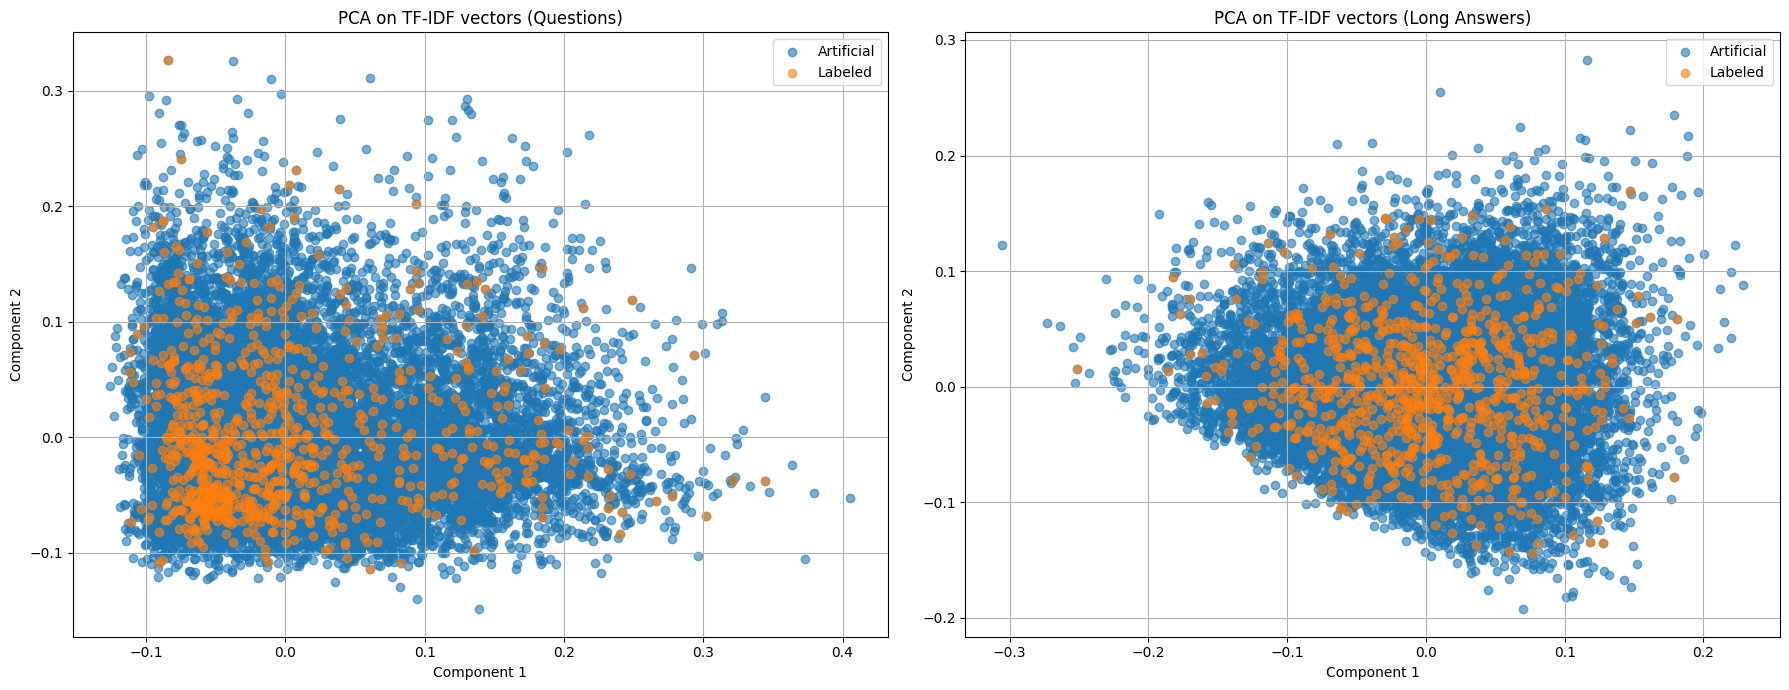

In [ ]:
# Apply PCA to the questions
pca_q = PCA(n_components=2)
X_Q_reduced = pca_q.fit_transform(X_Q_tfidf.toarray())  # Reduce the dimensionality of the question vectors

# Apply PCA to the long answers
pca_la = PCA(n_components=2)
X_LA_reduced = pca_la.fit_transform(X_LA_tfidf.toarray())  # Reduce the dimensionality of the long answer vectors

# Create a figure with 2 side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot for questions
for source in df_combined['source'].unique():  # Loop through each unique source (Artificial and Labeled)
    subset = df_combined[df_combined['source'] == source]  # Subset the data based on the source
    axes[0].scatter(
        X_Q_reduced[subset.index, 0],  # First principal component of the questions
        X_Q_reduced[subset.index, 1],  # Second principal component of the questions
        label=source,  # Label the points by source (Artificial or Labeled)
        alpha=0.6  # Set transparency for better visualization
    )
axes[0].set_title("PCA on TF-IDF vectors (Questions)")  
axes[0].set_xlabel("Component 1")  
axes[0].set_ylabel("Component 2")  
axes[0].legend()  
axes[0].grid(True) 

# Plot for long answers
for source in df_combined['source'].unique():  # Loop through each unique source (Artificial and Labeled)
    subset = df_combined[df_combined['source'] == source]  # Subset the data based on the source
    axes[1].scatter(
        X_LA_reduced[subset.index, 0],  # First principal component of the long answers
        X_LA_reduced[subset.index, 1],  # Second principal component of the long answers
        label=source,  
        alpha=0.6  
    )
    
axes[1].set_title("PCA on TF-IDF vectors (Long Answers)")  
axes[1].set_xlabel("Component 1")  
axes[1].set_ylabel("Component 2")  
axes[1].legend()  
axes[1].grid(True)  

plt.tight_layout()
plt.show()

# provare ad aggiungere contesto che era troppo lungo

In [ ]:
# We build separate TF-IDF vectorizers for the 'question' and 'long_answer' fields.
# First, we fit each vectorizer on the artificial (larger and noisier) dataset to extract the vocabulary and term weights.
# Then, we use the same fitted vectorizers to transform the labeled clean dataset, ensuring that both datasets are projected
# into the same feature space (i.e., with the same number and order of features).
# This is crucial because we want to train classification models on the artificial dataset (X_Q_tfidf_A and X_LA_tfidf_A),
# and then evaluate them on the clean labeled dataset (X_Q_tfidf_L and X_LA_tfidf_L), which serves as a reliable benchmark.
# Finally, we extract the corresponding labels for supervised learning (y_A for training, y_L for validation).

# We use TfidfVectorizer to convert the text data into TF-IDF features.

# Questions
vectorizer_q = TfidfVectorizer(max_features=50000)
X_Q_tfidf_A = vectorizer_q.fit_transform(df_artificial_sampled['question'])
X_Q_tfidf_L = vectorizer_q.transform(df_labeled_clean['question'])

# Long Answers
vectorizer_la = TfidfVectorizer(max_features=50000)
X_LA_tfidf_A = vectorizer_la.fit_transform(df_artificial_sampled['long_answer'])
X_LA_tfidf_L = vectorizer_la.transform(df_labeled_clean['long_answer'])

# Label
y_A = df_artificial_sampled['final_decision']
y_L = df_labeled_clean['final_decision']


In [ ]:
# The classification results were obtained by providing the classifier with only the questions (no long answers).
# Results on the labeled dataset are as follows:
# - SVM - Accuracy: 0.5326
# - Logistic Regression - Accuracy: 0.5281
# - Random Forest - Accuracy: 0.4472
# 
# The best model is SVM with an accuracy of 53.26%. However, the overall accuracy is relatively low,
# which could be due to the limited information provided by only using the questions without considering the long answers.
# This suggests that incorporating more contextual information (e.g., long answers) might improve the model's performance.

# We will train and evaluate several classifiers on the artificial dataset (X_Q_tfidf_A, y_A) and validate them on the labeled dataset (X_Q_tfidf_L, y_L).
# The classifiers include SVM, Logistic Regression, Random Forest.
models = {
    'SVM': SVC(C=1, kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=42, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_Q_tfidf_A, y_A)  
    y_pred = model.predict(X_Q_tfidf_L)  
    acc = accuracy_score(y_L, y_pred)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_L, best_model.predict(X_Q_tfidf_L)))


SVM - Accuracy on Labeled dataset: 0.5326
Logistic Regression - Accuracy on Labeled dataset: 0.5281
Random Forest - Accuracy on Labeled dataset: 0.4472

Best model on Labeled dataset: SVM with accuracy: 0.5326

Classification report:
              precision    recall  f1-score   support

          no       0.43      0.74      0.55       338
         yes       0.72      0.40      0.52       552

    accuracy                           0.53       890
   macro avg       0.58      0.57      0.53       890
weighted avg       0.61      0.53      0.53       890



In [ ]:
# In this cell, we train and evaluate multiple classifiers to identify the best-performing model
# when using only the 'long_answer' text as input features instead of the 'question' field.
# We vectorize the 'long_answer' using a TF-IDF representation, train on the artificial labeled dataset,
# and evaluate model performance on the clean labeled dataset. This setup allows us to assess
# whether the additional contextual information present in long answers improves classification accuracy.

# Results summary:
# When using the 'long_answer' field as input features (TF-IDF vectorized), all classifiers significantly outperform 
# those trained only on the 'question' field. The best model in this case is Logistic Regression, 
# achieving an accuracy of 77.64% on the labeled dataset.
# The classification report shows a strong performance for both classes, especially for the 'yes' class 
# with precision 0.83 and recall 0.80. These results suggest that long answers contain richer and more informative 
# content, allowing the model to better capture patterns associated with the final decision.

models = {
    'SVM': SVC(C=1, kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=42, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_LA_tfidf_A, y_A)  
    y_pred = model.predict(X_LA_tfidf_L)  
    acc = accuracy_score(y_L, y_pred)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_L, best_model.predict(X_LA_tfidf_L)))

SVM - Accuracy on Labeled dataset: 0.7753
Logistic Regression - Accuracy on Labeled dataset: 0.7764
Random Forest - Accuracy on Labeled dataset: 0.7506

Best model on Labeled dataset: Logistic Regression with accuracy: 0.7764

Classification report:
              precision    recall  f1-score   support

          no       0.69      0.74      0.72       338
         yes       0.83      0.80      0.82       552

    accuracy                           0.78       890
   macro avg       0.76      0.77      0.77       890
weighted avg       0.78      0.78      0.78       890



In [ ]:
# PER LA CLASSIFICAZIONE (COSE DA FARE)
# 1. fare la classificazione con gli embedding (CON LA STESSA PIPELINE PERò)
# 2. Fare vari classificatori e prendere i miglliori, classificare unlabeled e vedere quanto i modelli sono daccordo tra loro (di modo da rendere più robusta la classificazione)
# 3. in generale usare anche altri modelli di classificazione più complessi (XGBoost, LightGBM, ecc.) e vedere se migliorano i risultati

In [ ]:
# COSE DA FARE 
# 1. settare meglio tutta la parte del clustering (eventualmente provare altri algoritmi), sistemare i commenti, mettere delle considerazioni sui risultati
#   - NB Sperimentare anche di più per gli embedding
# 2. la classificazione (vedi sopra)
# 3. indexing documents per fare la keyword search

## Classification with Word2Vec



<h5> 
Prima di tutto sia il dataset artificial che quello labeled sono stati preprocessati:
 <ul>
 <li>Rimozione stopword 
 <li>lowercase
 <li>lemmmizzazione
 <li>Rimozione carartteri speciali e punteggiatura
 </ul>
 
 Successivamente i testi presenti nelle feature Question e long answer del dataset artificial sono stati usati per trainareo ad un modello word2vec, grazie al quale poi sono state create le rappresentazioni embeddind di tutti i testi contenuti nei suddetti attributi sia per il dataset artificial ceh per quello labeled.

 Sono stati poi presi in esame 3 classificatori SVM, Logistic regressio e Random Forest; Ogni classificatore è stato trainato con gli embedding del dataset artificial e testato sul datatset labeled. 
 Per valutare il peso delle diverse features nella classificazione è stata performata una classificazione usando come features solo gli emebedding contenuti in questions, una considerando sono quelli contenuti in Long_answer e infine una considerando come features entrambi i vettori embedding sia della question che della long answer
</h5>

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Scarica risorse NLTK (solo la prima volta)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.isalpha()]                # solo parole (niente punteggiatura/numero)
    tokens = [w for w in tokens if w not in stop_words]        # rimuovi stopwords
    tokens = [lemmatizer.lemmatize(w) for w in tokens]         # lemmatizzazione
    return tokens

# Applica il preprocessing
sentences_q_A = df_artificial_sampled['question'].apply(preprocess).tolist()
sentences_la_A = df_artificial_sampled['long_answer'].apply(preprocess).tolist()
sentences_q_L = df_labeled_clean['question'].apply(preprocess).tolist()
sentences_la_L = df_labeled_clean['long_answer'].apply(preprocess).tolist()


# sentences_all_A = sentences_q_A + sentences_la_A
# w2v_model = Word2Vec(sentences_all_A, vector_size=100, window=5, min_count=2, workers=4, sg=1)

w2v_model_q_A = Word2Vec(sentences_q_A, vector_size=100, window=5, min_count=2, workers=4, sg=1)
w2v_model_la_A = Word2Vec(sentences_la_A, vector_size=100, window=5, min_count=2, workers=4, sg=1)

# # Train word2vec
# w2v_model_q_A = Word2Vec(sentences_q_A, vector_size=100, window=5, min_count=2, workers=4, sg=1)
# w2v_model_la_A = Word2Vec(sentences_la_A, vector_size=100, window=5, min_count=2, workers=4, sg=1)

# w2v_model_q_L = Word2Vec(sentences_q_L, vector_size=100, window=5, min_count=2, workers=4, sg=1)
# w2v_model_la_L = Word2Vec(sentences_la_L, vector_size=100, window=5, min_count=2, workers=4, sg=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
import numpy as np
def vectorize(tokens, model, vector_size):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

# df_artificial_sampled['Question_embedding'] = df_artificial_sampled['question'].apply(lambda x: vectorize(x, w2v_model_q_A, 100))
# df_artificial_sampled['Longanswer_embedding'] = df_artificial_sampled['long_answer'].apply(lambda x: vectorize(x, w2v_model_la_A, 100))

# df_labeled_clean['Question_embedding'] = df_labeled_clean['question'].apply(lambda x: vectorize(x, w2v_model_q_L, 100))
# df_labeled_clean['Longanswer_embedding'] = df_labeled_clean['long_answer'].apply(lambda x: vectorize(x, w2v_model_la_L, 100))

df_artificial_sampled['Question_embedding'] = df_artificial_sampled['question'].apply(lambda x: vectorize(x, w2v_model_q_A, 100))
df_artificial_sampled['Longanswer_embedding'] = df_artificial_sampled['long_answer'].apply(lambda x: vectorize(x, w2v_model_la_A, 100))

df_labeled_clean['Question_embedding'] = df_labeled_clean['question'].apply(lambda x: vectorize(x, w2v_model_q_A, 100))
df_labeled_clean['Longanswer_embedding'] = df_labeled_clean['long_answer'].apply(lambda x: vectorize(x, w2v_model_la_A, 100))

# df_artificial_sampled['Question_embedding'] = df_artificial_sampled['question'].apply(lambda x: vectorize(x, w2v_model, 100))
# df_artificial_sampled['Longanswer_embedding'] = df_artificial_sampled['long_answer'].apply(lambda x: vectorize(x, w2v_model, 100))

# df_labeled_clean['Question_embedding'] = df_labeled_clean['question'].apply(lambda x: vectorize(x, w2v_model, 100))
# df_labeled_clean['Longanswer_embedding'] = df_labeled_clean['long_answer'].apply(lambda x: vectorize(x, w2v_model, 100))


In [33]:
df_artificial_sampled.head()

pubid                                           question  \
0  11289484  Does blood pressure rise before the onset of m...   
1  16969853  Does systemic immunosuppressive therapy inhibi...   
2  19026002  Does bile duct proliferation in Jag1/fringe he...   
3  15525465  Does capsaicin facilitate carotid sinus barore...   
4  17601704  Is the catechol O-methyltransferase Val158Met ...   

                                             context  \
0  {'contexts': ['To examine whether a rise in bl...   
1  {'contexts': ['Cyclosporine is used routinely ...   
2  {'contexts': ['Alagille syndrome (AGS) is a he...   
3  {'contexts': ['To study the effect of capsaici...   
4  {'contexts': ['A valine/methionine polymorphis...   

                                         long_answer final_decision  \
0  A rise in systemic BP cannot be detected befor...             no   
1  Renal transplant patients receiving combined i...            yes   
2  Mice heterozygous for mutations in Jag1 and th...            yes   
3  Capsaicin exerts a facilitatory role on the is...            yes   
4  Based on the results in our sample, the catech...             no   

       source                                 Question_embedding  \
0  Artificial  [-0.08141242, 0.17194721, 0.036313046, -0.0771...   
1  Artificial  [-0.09368355, 0.15847664, 0.0273304, -0.092121...   
2  Artificial  [-0.10369821, 0.170552, 0.029946662, -0.088623...   
3  Artificial  [-0.12218171, 0.22197425, 0.048641503, -0.0605...   
4  Artificial  [-0.10881213, 0.19610393, 0.037229672, -0.0785...   

                                Longanswer_embedding  \
0  [-0.15525508, 0.33304664, -0.046376634, 0.0962...   
1  [-0.15354548, 0.3287968, -0.03777212, 0.086415...   
2  [-0.15430926, 0.35111237, -0.056414623, 0.0795...   
3  [-0.14556803, 0.34048536, -0.04385718, 0.09591...   
4  [-0.13450615, 0.34048647, -0.04871485, 0.07997...   

                                      combined_embed  
0  [-0.25509214, 0.06350461, 0.10533437, -0.01171...  
1  [-0.21021795, 0.054669507, 0.12091969, -0.0291...  
2  [-0.23568709, 0.07970406, 0.11688894, -0.00650...  
3  [-0.22975089, 0.037652656, 0.12154434, 0.01070...  
4  [-0.22036138, 0.064764984, 0.10770759, 0.00246...

In [34]:
df_labeled_clean.head()

pubid                                           question  \
0  21645374  Do mitochondria play a role in remodelling lac...   
1  16418930  Landolt C and snellen e acuity: differences in...   
2   9488747  Syncope during bathing in infants, a pediatric...   
3  17208539  Are the long-term results of the transanal pul...   
4  10808977  Can tailored interventions increase mammograph...   

                                             context  \
0  {'contexts': ['Programmed cell death (PCD) is ...   
1  {'contexts': ['Assessment of visual acuity dep...   
2  {'contexts': ['Apparent life-threatening event...   
3  {'contexts': ['The transanal endorectal pull-t...   
4  {'contexts': ['Telephone counseling and tailor...   

                                         long_answer final_decision   source  \
0  Results depicted mitochondrial dynamics in viv...            yes  Labeled   
1  Using the charts described, there was only a s...             no  Labeled   
2  "Aquagenic maladies" could be a pediatric form...            yes  Labeled   
3  Our long-term study showed significantly bette...             no  Labeled   
4  The effects of the intervention were most pron...            yes  Labeled   

                                  Question_embedding  \
0  [-0.10227115, 0.16460769, 0.02481446, -0.08853...   
1  [-0.08822964, 0.196327, 0.040437125, -0.067721...   
2  [-0.09247802, 0.19091246, 0.04149088, -0.06787...   
3  [-0.06677309, 0.14058207, 0.030123012, -0.0876...   
4  [-0.09830495, 0.14759609, 0.021250153, -0.0901...   

                                Longanswer_embedding  \
0  [-0.15035678, 0.34097025, -0.050083775, 0.0819...   
1  [-0.1531432, 0.3358335, -0.04472522, 0.0821995...   
2  [-0.18375535, 0.32618842, -0.042463996, 0.0656...   
3  [-0.1574845, 0.33846897, -0.046144154, 0.08415...   
4  [-0.15853949, 0.3495914, -0.055185363, 0.08919...   

                                      combined_embed  
0  [-0.23691583, 0.066630796, 0.11564617, -0.0107...  
1  [-0.22965248, 0.057061646, 0.12432225, -0.0131...  
2  [-0.20429465, 0.034050096, 0.10003554, -0.0165...  
3  [-0.21745074, 0.08143397, 0.091689855, -0.0242...  
4  [-0.22072268, 0.0443645, 0.12127596, -0.018063...

In [35]:
# Only question
X_q_A = np.vstack(df_artificial_sampled['Question_embedding'].values)
y_q_A = df_artificial_sampled['final_decision'].map({'no': 0, 'yes': 1}).values

X_q_L = np.vstack(df_labeled_clean['Question_embedding'].values)
y_q_L = df_labeled_clean['final_decision'].map({'no': 0, 'yes': 1}).values

# Only long answer
X_la_A = np.vstack(df_artificial_sampled['Longanswer_embedding'].values)
y_la_A = df_artificial_sampled['final_decision'].map({'no': 0, 'yes': 1}).values

X_la_L = np.vstack(df_labeled_clean['Longanswer_embedding'].values)
y_la_L = df_labeled_clean['final_decision'].map({'no': 0, 'yes': 1}).values


#### Only question

In [36]:
models = {
    'SVM': SVC(C=1, kernel='linear', random_state=23, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=23, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=23, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_q_A, y_q_A)  
    y_pred_q = model.predict(X_q_L)  
    acc = accuracy_score(y_q_L, y_pred_q)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_q_L, best_model.predict(X_q_L)))

SVM - Accuracy on Labeled dataset: 0.5101
Logistic Regression - Accuracy on Labeled dataset: 0.5124
Random Forest - Accuracy on Labeled dataset: 0.5270

Best model on Labeled dataset: Random Forest with accuracy: 0.5270

Classification report:
              precision    recall  f1-score   support

           0       0.40      0.49      0.44       338
           1       0.64      0.55      0.59       552

    accuracy                           0.53       890
   macro avg       0.52      0.52      0.52       890
weighted avg       0.55      0.53      0.53       890



#### Only long answer

In [37]:
models = {
    'SVM': SVC(C=1, kernel='linear', random_state=23, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=23, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=23, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_la_A, y_la_A)  
    y_pred_la = model.predict(X_la_L)  
    acc = accuracy_score(y_la_L, y_pred_la)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_la_L, best_model.predict(X_la_L)))

SVM - Accuracy on Labeled dataset: 0.5831
Logistic Regression - Accuracy on Labeled dataset: 0.5730
Random Forest - Accuracy on Labeled dataset: 0.5933

Best model on Labeled dataset: Random Forest with accuracy: 0.5933

Classification report:
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       338
           1       0.69      0.61      0.65       552

    accuracy                           0.59       890
   macro avg       0.58      0.59      0.58       890
weighted avg       0.61      0.59      0.60       890



#### Both question and long answer

In [38]:

df_artificial_sampled['combined_embed'] = df_artificial_sampled.apply(
    lambda row: np.concatenate([row['Question_embedding'], row['Longanswer_embedding']]),
    axis=1
)

X_A = np.vstack(df_artificial_sampled['combined_embed'].values)
y_A = df_artificial_sampled['final_decision'].map({'no': 0, 'yes': 1}).values

df_labeled_clean['combined_embed'] = df_labeled_clean.apply(
    lambda row: np.concatenate([row['Question_embedding'], row['Longanswer_embedding']]),
    axis=1
)

X_L = np.vstack(df_labeled_clean['combined_embed'].values)
y_L = df_labeled_clean['final_decision'].map({'no': 0, 'yes': 1}).values

In [39]:
models = {
    'SVM': SVC(C=1, kernel='linear', random_state=23, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=23, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=23, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_A, y_A)  
    y_pred = model.predict(X_L)  
    acc = accuracy_score(y_L, y_pred)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_L, best_model.predict(X_L)))

SVM - Accuracy on Labeled dataset: 0.5674
Logistic Regression - Accuracy on Labeled dataset: 0.5629
Random Forest - Accuracy on Labeled dataset: 0.5775

Best model on Labeled dataset: Random Forest with accuracy: 0.5775

Classification report:
              precision    recall  f1-score   support

           0       0.46      0.58      0.51       338
           1       0.69      0.58      0.63       552

    accuracy                           0.58       890
   macro avg       0.57      0.58      0.57       890
weighted avg       0.60      0.58      0.58       890



<h5>
In tutti e 3 i casi le performance dei classificatori peggiorano rispetto alla precedente analisi fatta con tf-idf.
Word2Vec, pur essendo efficace nel catturare le relazioni semantiche tra parole grazie ai suoi vettori densi appresi in base al contesto, presenta alcune limitazioni nei compiti di classificazione. In particolare, non tiene conto direttamente della frequenza delle parole nei documenti né della loro posizione, se non in modo indiretto attraverso la finestra di contesto. Di conseguenza, quando si rappresenta un documento tramite la media dei vettori delle parole, si perde informazione importante legata alla distribuzione e all'importanza delle parole nel testo. Al contrario, TF-IDF rappresenta ogni documento come un vettore sparso che riflette le frequenze pesate delle parole, enfatizzando quelle rare ma potenzialmente discriminanti per la classificazione, e penalizzando le parole troppo comuni. Mentre Word2Vec è un modello non supervisionato orientato al significato, TF-IDF si rivela spesso più efficace per compiti supervisionati poiché evidenzia direttamente le caratteristiche utili alla distinzione tra classi.
</h5>

## Embedding Techniques: BioBERT + HDBSCAN for Unlabeled Dataset Clustering.

We tried to appy clustering techniques to explore the natural structure of the dataset. As could be expected, this dataset is not particularly suitable for such an approach.

### Pipeline: 
- Use BioBERT to obtain embeddings after merging question+contexts. 
- Apply HDBSCAN to the embeddings to perform clustering on the Unlabeled Dataset.
- Analyze clustering to understand latent groupings in unlabeled biomedical QA data 

In [ ]:
# This is the code to obtain biobert_embeddings.npy

'''from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import os

# Carica tokenizer e modello BioBERT
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model.eval()

# Usa GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Funzione per estrarre embedding CLS
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return cls_embedding.squeeze().cpu().numpy()  # numpy array

# Percorso del file per salvare gli embeddings progressivamente
# Modifica il percorso per salvare su Google Drive
embedding_file = '/content/drive/MyDrive/BioBERT-Google-Colab/biobert_embeddings.npy'


# Se il file esiste già, carica gli embeddings precedenti
if os.path.exists(embedding_file):
    embeddings_array = np.load(embedding_file)
else:
    embeddings_array = []

# Imposta il numero di iterazioni per il salvataggio progressivo
batch_size = 1000  # Salva ogni 1000 embeddings

# Applica a tutto il dataset con tqdm
for i, text in tqdm(enumerate(df_unlabeled['full_text']), total=len(df_unlabeled)):
    emb = get_cls_embedding(text)
    embeddings_array.append(emb)
    
    # Salva ogni 'batch_size' embeddings
    if (i + 1) % batch_size == 0:
        np.save(embedding_file, np.array(embeddings_array))
        print(f"Salvato progressivamente fino all'elemento {i+1}")
    
# Dopo aver completato il ciclo, salva gli embeddings finali
np.save(embedding_file, np.array(embeddings_array))

'''

In [ ]:
import numpy as np
# It is necessary to instert the path to the file in your computer

embeddings_biobert = np.load("biobert_embeddings.npy")
print(embeddings_biobert.shape)

(61249, 768)


### Clustering with HDBSCAN

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Riduci la dimensionalità degli embedding
# tsne = TSNE(n_components=2, random_state=42)
# embeddings_2d = tsne.fit_transform(embeddings_biobert)

# # Visualizza i risultati
# plt.figure(figsize=(10, 8))
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# plt.title('t-SNE visualization of BioBERT embeddings')
# plt.show()

c:\Users\ASUS\Desktop\Progetto\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\Desktop\Progetto\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


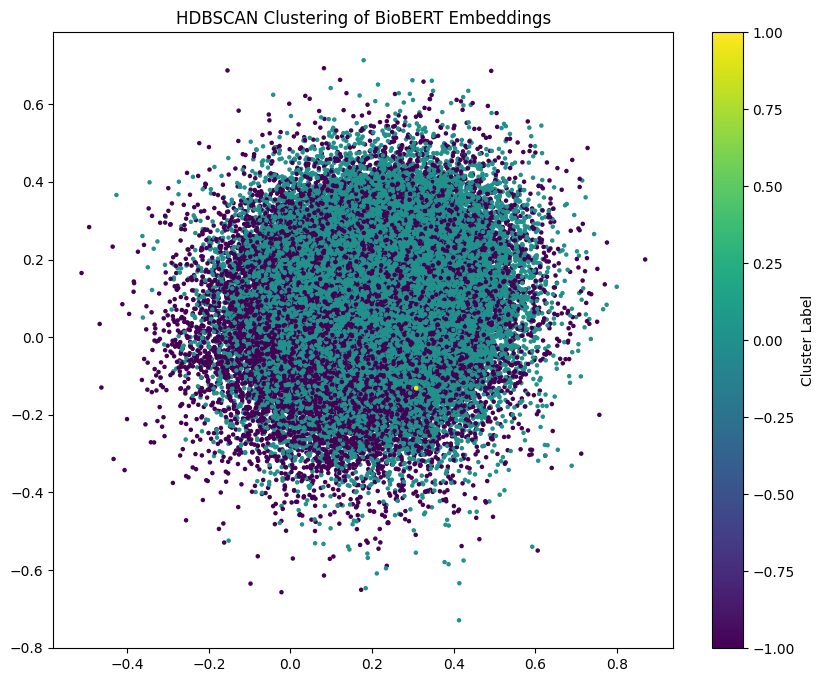

In [ ]:
from hdbscan import HDBSCAN

# Crea e addestra il modello HDBSCAN
clusterer = HDBSCAN(min_cluster_size=5)
cluster_labels_biobert = clusterer.fit_predict(embeddings_biobert)

# Visualizza i cluster
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_biobert[:, 0], embeddings_biobert[:, 1], c=cluster_labels_biobert, cmap='viridis', s=5)
plt.title('HDBSCAN Clustering of BioBERT Embeddings')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
# Adding the label to the main dataframe
df_unlabeled['cluster_biobert'] = cluster_labels_biobert

NameError: name 'df_unlabeled' is not defined

In [ ]:
import numpy as np

# This excludes the outliers 
n_clusters = len(set(cluster_labels_biobert)) - (1 if -1 in cluster_labels_biobert else 0)
print(f"Number of clusters in total (excluding outliers): {n_clusters}")

Number of clusters in total (excluding outliers): 3148


In [ ]:
noise_ratio = np.sum(cluster_labels_biobert == -1) / len(cluster_labels_biobert)
print(f"Percentuale di noise: {noise_ratio:.2%}")

Percentuale di noise: 35.83%


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Filters only NON noise points (label != -1)
mask = cluster_labels_biobert != -1
filtered_embeddings = embeddings_biobert[mask]
filtered_labels = cluster_labels_biobert[mask]

# Calculates number of real clusters (excluding -1)
n_clusters = len(set(filtered_labels))


score = silhouette_score(filtered_embeddings, filtered_labels)
print(f"Silhouette Score (without outliers): {score:.4f}")

Silhouette Score (senza outlier): 0.0084


### Clustering with HDBSCAN

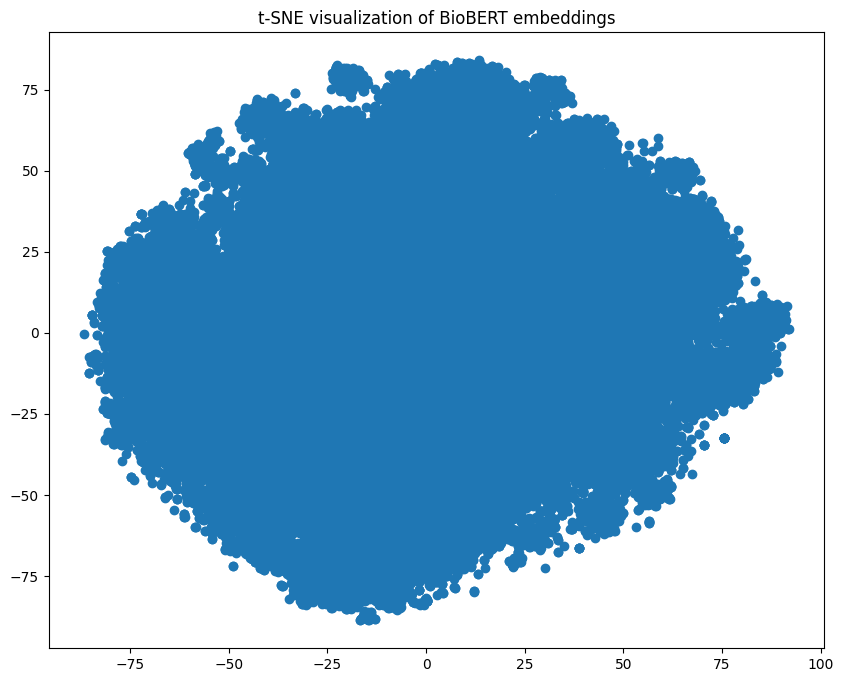

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Riduci la dimensionalità degli embedding
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_biobert)

# Visualizza i risultati
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title('t-SNE visualization of BioBERT embeddings')
plt.show()


C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


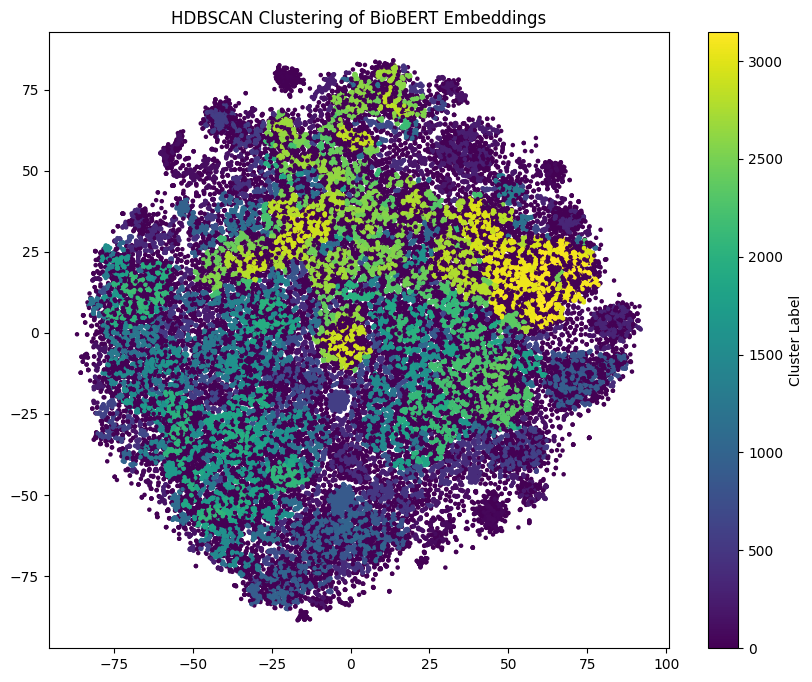

In [ ]:
from hdbscan import HDBSCAN

# Crea e addestra il modello HDBSCAN
clusterer = HDBSCAN(min_cluster_size=5)
cluster_labels_biobert = clusterer.fit_predict(embeddings_2d)

# Visualizza i cluster
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels_biobert, cmap='viridis', s=5)
plt.title('HDBSCAN Clustering of BioBERT Embeddings')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
# Adding the label to the main dataframe
df_unlabeled['cluster_biobert'] = cluster_labels_biobert

In [ ]:
import numpy as np

# This excludes the outliers 
n_clusters = len(set(cluster_labels_biobert)) - (1 if -1 in cluster_labels_biobert else 0)
print(f"Number of clusters in total (excluding outliers): {n_clusters}")

Number of clusters in total (excluding outliers): 3148


In [ ]:
noise_ratio = np.sum(cluster_labels_biobert == -1) / len(cluster_labels_biobert)
print(f"Percentuale di noise: {noise_ratio:.2%}")

Percentuale di noise: 35.83%


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Filters only NON noise points (label != -1)
mask = cluster_labels_biobert != -1
filtered_embeddings = embeddings_biobert[mask]
filtered_labels = cluster_labels_biobert[mask]

# Calculates number of real clusters (excluding -1)
n_clusters = len(set(filtered_labels))


score = silhouette_score(filtered_embeddings, filtered_labels)
print(f"Silhouette Score (without outliers): {score:.4f}")

Silhouette Score (senza outlier): 0.0084


## Named Entity Recognition (NER) and BioBERT Fine-Tuning

Named Entity Recognition (NER) is a Natural Language Processing (NLP) task that involves identifying and classifying key information (entities) in text into predefined categories such as people, locations, organizations, or—in the biomedical context—diseases, chemicals, and genes. In our project, we use NER to automatically extract relevant biomedical entities from unstructured text. This is a crucial step for downstream tasks such as document classification, clustering, and knowledge extraction.

To improve the performance of entity recognition on biomedical data, we fine-tuned the [BioBERT](https://github.com/dmis-lab/biobert) model, a domain-specific language representation model pre-trained on large-scale biomedical corpora.

### Fine-Tuning on Google Colab
To speed up the computational process and make the pipeline more accessible to other users, we chose to perform the fine-tuning on Google Colab. You can find our Colab notebook at the following link:

🔗 [Fine-Tuning BioBERT on Google Colab](https://colab.research.google.com/drive/1fEpiZbmUZJWfDV2dpQjRw81nPtgeh2lm?usp=sharing)

### Dataset Selection
To select the most suitable dataset for fine-tuning, we referred to the official [BioBERT GitHub repository](https://github.com/dmis-lab/biobert-pytorch/tree/master/named-entity-recognition), which includes several benchmark biomedical NER datasets. Based on the coverage and reported performance in the paper by [Lee et al., 2019](https://doi.org/10.1093/bioinformatics/btz682), we selected the BC5CDR dataset.

This dataset is particularly well-suited to our goals, as it contains annotations for both chemical substances (e.g., drugs) and diseases, enabling a more comprehensive evaluation and application of the fine-tuned model in biomedical text analysis.